<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
  <h1 style="color:#2c3e50;">به نام خدا</h1>

  <h2 style="color:#34495e;">گروه: G3G4</h2>
  <p><strong>منتور:</strong> شادلین</p>
  <p><strong>موضوع دیتاست:</strong> دیجیتال مارکتینگ – تحلیل نرخ تبدیل (Conversion)</p>

  <p>
    در ادامه، تحلیل‌های آماری و تصویری برای هر ویژگی ارائه شده و روابط معنادار بین متغیرها بررسی شده‌اند.
  </p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
  <h2 style="color:#2c3e50;">کتاب‌خانه‌ها و توابع</h2>
</div>

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import warnings
import json
import re
import matplotlib.patches as mpatches
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency


In [271]:
def describe_numerical_col(df, col_name):
    info = df[[col_name]].describe().to_dict()[col_name]
    info['shapiro'] = f'{stats.shapiro(df[col_name])[1]: .5f}'
    info['normal'] = float(info['shapiro']) > 0.05
    info['missing'] = df[col_name].isna().sum()
    info['skew'] = f'{stats.skew(df[col_name]):.5f}'
    info['type'] = ('slight ' if info['normal'] else '') + \
                   ('right(positive)' if float(info['skew']) > 0 else 'left(negative)') + '-skew'

    fig, ax = plt.subplots(2, 2, figsize=(16, 7), gridspec_kw={'height_ratios': (.85, .15)})
    sns.histplot(df[col_name], kde=True, ax=ax[0, 0], color='#55A868')
    sns.boxplot(df[col_name], orient='h', ax=ax[1, 0], color="#5583A8")
    # محاسبه outliers
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    lower_outliers = df[col_name][df[col_name] < lower_bound]
    upper_outliers = df[col_name][df[col_name] > upper_bound]
    total_outliers = len(lower_outliers) + len(upper_outliers)
    percent_outliers = 100 * total_outliers / len(df[col_name])
    label_text = (
        f"Lower Outliers: {len(lower_outliers)}\n"
        f"Upper Outliers: {len(upper_outliers)}\n"
        f"Total: {total_outliers} ({percent_outliers:.1f}%)"
    )
    patch = mpatches.Patch(color='skyblue', label=label_text)
    ax[1, 0].legend(handles=[patch], fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))
    # پایان outliers
    counts, bin_edges = np.histogram(df[col_name], bins=10, density=True)
    pdf = counts / (sum(counts))
    cdf = np.cumsum(pdf)
    ax[1, 1] = plt.subplot(122)
    plt.plot(bin_edges[1:], pdf, label='PDF')
    plt.plot(bin_edges[1:], cdf, label='CDF')
    plt.legend()
    ax[0, 0].set_xticklabels([])
    ax[1, 0].set_yticklabels([])
    ax[0, 0].set_xlabel('')
    ax[0, 0].set_ylabel('Count')
    fig.suptitle(col_name, fontsize=30)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('=' * 18 + ' ' + col_name + ' ' + '=' * 18)
    print(info_df)
    print('=' * 40)

In [272]:
def categorize_numerical_col(df, col_name, bins, bins_name):
    new_col = f'{col_name}_categorized'
    df[new_col] = pd.cut(df[col_name], bins=bins, labels=bins_name)
    return df

In [273]:
def describe_categorical_col(df, col_name):
    counts = pd.DataFrame(df[col_name].value_counts()).reset_index()
    counts.columns = ['Group', 'Count']
    total = sum(counts['Count'])
    counts['%'] = (counts['Count'] / total * 100).round(2)

    fig = px.pie(
        counts,
        names='Group',
        values='Count',
        title=f'<b>Distribution of {col_name} in each group</b>',
        color='Group',
        hole=0.3
    )

    fig.update_traces(
        textposition='inside',
        textinfo='percent+label',

    )

    fig.update_layout(
        title_x=0.5,
        legend_title_text='Groups',
        font=dict(family="Arial, sans-serif", size=14)
    )
    fig.show()
    print('=' * 18 + ' ' + col_name + ' ' + '=' * 18)
    print(counts)
    print('=' * 40)

In [274]:
def describe_num_num_relationship(df, col1, col2):
    # آزمون نرمال بودن با شاپیرو
    shapiro1_stat, shapiro1_p = stats.shapiro(df[col1])
    shapiro2_stat, shapiro2_p = stats.shapiro(df[col2])

    # تشخیص نرمال بودن (p > 0.05 یعنی نرمال)
    is_normal1 = shapiro1_p > 0.05
    is_normal2 = shapiro2_p > 0.05
    both_normal = is_normal1 and is_normal2

    # انتخاب آزمون مناسب
    if both_normal:
        # استفاده از پیرسون
        corr_stat, p_value = stats.pearsonr(df[col1], df[col2])
        test_used = 'Pearson'
        correlation = corr_stat
    else:
        # استفاده از اسپیرمن
        corr_stat, p_value = stats.spearmanr(df[col1], df[col2])
        test_used = 'Spearman'
        correlation = corr_stat

    r2_score = correlation ** 2

    info = {
        'shapiro_p_col1': f'{shapiro1_p:.5f}',
        'shapiro_p_col2': f'{shapiro2_p:.5f}',
        'col1_normal': is_normal1,
        'col2_normal': is_normal2,
        'test_used': test_used,
        'correlation': f'{correlation:.5f}',
        'r_squared': f'{r2_score:.5f}',
        'p_value': f'{p_value:.5f}',
        'significant': p_value < 0.05,
        'relationship_strength': 'strong' if abs(correlation) > 0.7 else 'moderate' if abs(
            correlation) > 0.3 else 'weak',
        'relationship_direction': 'positive' if correlation > 0 else 'negative'
    }

    # رسم نمودار
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{col1} vs {col2} - {test_used} Correlation', fontsize=14)

    # Scatter Plot
    axes[0].scatter(df[col1], df[col2],
                    s=60, alpha=0.7, color='blue', edgecolors='black', linewidth=0.5)
    axes[0].set_title('Scatter Plot')
    axes[0].set_xlabel(col1)
    axes[0].set_ylabel(col2)
    axes[0].grid(True, alpha=0.3)

    # Hexbin Plot
    axes[1].hexbin(df[col1], df[col2], gridsize=20, cmap='Blues', mincnt=1)
    axes[1].set_title('Hexbin Plot')
    axes[1].set_xlabel(col1)
    axes[1].set_ylabel(col2)
    axes[1].yaxis.set_label_position("right")

    plt.tight_layout()
    plt.show()

    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('=' * 15 + f' {col1} vs {col2} ' + '=' * 15)
    print(info_df)
    print('=' * 50)

In [275]:
def describe_cat_num_relationship(df, cat_col, num_col):
    # محاسبه آمار
    groups = df.groupby(cat_col)[num_col].describe()

    # آزمون نرمال بودن با شاپیرو برای هر گروه
    normality_results = {}
    group_data = []
    all_normal = True

    for name, group in df.groupby(cat_col):
        if len(group) >= 3:  # شاپیرو حداقل 3 داده نیاز داره
            shapiro_stat, shapiro_p = stats.shapiro(group[num_col])
            is_normal = shapiro_p > 0.05
            normality_results[name] = {
                'shapiro_p': f'{shapiro_p:.5f}',
                'is_normal': is_normal
            }
            if not is_normal:
                all_normal = False
        else:
            normality_results[name] = {
                'shapiro_p': 'N/A (too few data)',
                'is_normal': False
            }
            all_normal = False

        group_data.append(group[num_col].values)

    # انتخاب آزمون مناسب
    if all_normal:
        # استفاده از ANOVA معمولی
        f_stat, p_value = stats.f_oneway(*group_data)
        test_used = 'ANOVA'
    else:
        # استفاده از Welch's ANOVA
        try:
            from scipy.stats import alexandergovern
            # اگر alexandergovern موجود نباشه، از kruskal استفاده می‌کنیم
            result = alexandergovern(*group_data)
            f_stat, p_value = result.statistic, result.pvalue
            test_used = "Welch's ANOVA"
        except ImportError:
            # fallback به Kruskal-Wallis (non-parametric)
            f_stat, p_value = stats.kruskal(*group_data)
            test_used = 'Kruskal-Wallis (non-parametric)'

    info = {
        'test_used': test_used,
        'all_groups_normal': all_normal,
        'f_statistic': f'{f_stat:.5f}',
        'p_value': f'{p_value:.5f}',
        'significant_difference': p_value < 0.05,
        'num_categories': df[cat_col].nunique(),
        'total_observations': len(df)
    }

    # رسم نمودار
    fig = plt.subplots(2, 2, figsize=(14, 10))

    # Box plot
    ax1 = plt.subplot(221)
    sns.boxplot(data=df, x=cat_col, y=num_col)
    ax1.set_title(f'{num_col} by {cat_col}')
    plt.xticks(rotation=45)

    # Violin plot
    ax2 = plt.subplot(222)
    sns.violinplot(data=df, x=cat_col, y=num_col)
    ax2.set_title(f'{num_col} Distribution by {cat_col}')
    plt.xticks(rotation=45)

    # Bar plot of means
    ax3 = plt.subplot(223)
    means = df.groupby(cat_col)[num_col].mean().sort_values(ascending=False)
    sns.barplot(x=means.index, y=means.values)
    ax3.set_title(f'Mean {num_col} by {cat_col}')
    plt.xticks(rotation=45)

    # Count plot of categories
    ax4 = plt.subplot(224)
    sns.countplot(data=df, x=cat_col)
    ax4.set_title(f'Count of {cat_col}')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print('=' * 15 + f' {cat_col} vs {num_col} ' + '=' * 15)
    print("Group Statistics:")
    print(groups)
    print(f"\nNormality Test Results (Shapiro-Wilk):")
    for group_name, result in normality_results.items():
        print(f"{group_name}: p-value = {result['shapiro_p']}, Normal = {result['is_normal']}")
    print(f"\n{test_used} Test Results:")
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print(info_df)
    print('=' * 50)



In [276]:
def describe_cat_cat_relationship(df, col1, col2):
    # جدول تطبیقی
    contingency_table = pd.crosstab(df[col1], df[col2])

    # آزمون کای دو
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    # ضریب کرامر V
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

    info = {
        'chi2_statistic': f'{chi2:.5f}',
        'p_value': f'{p_value:.5f}',
        'degrees_of_freedom': dof,
        'cramers_v': f'{cramers_v:.5f}',
        'association_strength': 'strong' if cramers_v > 0.3 else 'moderate' if cramers_v > 0.1 else 'weak',
        'significant_association': p_value < 0.05
    }

    # رسم نمودار
    fig = plt.subplots(2, 2, figsize=(14, 10))

    # Heatmap of contingency table
    ax1 = plt.subplot(221)
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
    ax1.set_title(f'Contingency Table: {col1} vs {col2}')

    # Stacked bar chart
    ax2 = plt.subplot(222)
    contingency_table.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title(f'Stacked Bar: {col1} vs {col2}')
    plt.xticks(rotation=45)

    # Normalized heatmap (percentages)
    ax3 = plt.subplot(223)
    normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    sns.heatmap(normalized, annot=True, fmt='.2%', cmap='Oranges')
    ax3.set_title(f'Normalized Contingency Table')

    # Count plots side by side
    ax4 = plt.subplot(224)
    df_melted = df[[col1, col2]].melt()
    sns.countplot(data=df_melted, x='value', hue='variable')
    ax4.set_title(f'Count Comparison')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print('=' * 15 + f' {col1} vs {col2} ' + '=' * 15)
    print("Contingency Table:")
    print(contingency_table)
    print("\nChi-square Test Results:")
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print(info_df)
    print('=' * 50)


In [277]:
def describe_target_relationship(df, feature_col, target_col):
    if df[feature_col].dtype in ['object', 'category']:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_cat_relationship(df, feature_col, target_col)
        else:
            describe_cat_num_relationship(df, feature_col, target_col)
    else:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_num_relationship(df, target_col, feature_col)
        else:
            describe_num_num_relationship(df, feature_col, target_col)

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
  <h2 style="color:#2c3e50;">وارد کردن دیتا و اطلاعات اولیه</h2>
</div>

In [278]:
df = pd.read_csv('marketing.csv')

In [279]:
df.shape

(2010, 20)

In [280]:
df.head(20)

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,13300,36,Female,47648.0,Email,Consideration,893.7554921892273,0.132078,0.198063,38,6.900081,11.923316,9,3,6,1,1139,IsConfid,ToolConfid,1
1,10429,32,Female,47491.0,Email,Consideration,7330.251375088103,0.120810,0.088416,27,4.589390,NaN,33,0,2,4,3772,IsConfid,ToolConfid,1
2,10557,52,Male,83830.0,Referral,Awareness,7720.360685483039,0.125472,0.082197,35,7.403157,0.660581,29,1,3,0,3611,IsConfid,ToolConfid,1
3,12602,52,Male,116342.0,Social Media,Consideration,8337.45315727269,0.158739,0.089032,25,9.367090,12.218421,72,3,7,4,1173,IsConfid,ToolConfid,1
4,8592,58,Female,90994.0,Email,Retention,5273.098832292671,0.226054,0.099792,13,7.968767,4.894079,41,16,7,0,1102,IsConfid,ToolConfid,1
5,9926,28,Male,NaN,PPC,Conversion,6140.692084655652,0.290509,0.061431,8,2.342393,NaN,79,17,3,7,902,IsConfid,ToolConfid,1
6,8926,25,Male,45493.0,SEO,Retention,9580.333882970706,0.181050,0.105205,7,4.205543,3.870341,37,11,6,2,3157,IsConfid,ToolConfid,1
7,8934,44,Male,56253.0,PPC,Consideration,7257.788852501013,0.059053,0.139160,14,8.027403,1.555812,34,12,1,4,3289,IsConfid,ToolConfid,1
8,14022,33,Female,127318.0,Social Media,Conversion,1893.8409330689187,0.061941,0.111206,5,4.829093,11.948463,13,7,0,2,4968,IsConfid,ToolConfid,1
9,10706,59,Female,108909.0,Referral,Conversion,526.0384147362745,0.035578,0.103091,25,9.625184,11.462090,89,10,9,0,374,IsConfid,ToolConfid,1


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2010 non-null   int64  
 1   Age                  2010 non-null   int64  
 2   Gender               2010 non-null   object 
 3   Income               1931 non-null   float64
 4   CampaignChannel      1856 non-null   object 
 5   CampaignType         2010 non-null   object 
 6   AdSpend              2010 non-null   object 
 7   ClickThroughRate     2010 non-null   float64
 8   ConversionRate       2010 non-null   float64
 9   WebsiteVisits        2010 non-null   int64  
 10  PagesPerVisit        2010 non-null   float64
 11  TimeOnSite           1931 non-null   float64
 12  SocialShares         2010 non-null   int64  
 13  EmailOpens           2010 non-null   int64  
 14  EmailClicks          2010 non-null   int64  
 15  PreviousPurchases    2010 non-null   i

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<p>ستون AdSpend دیتا تایپ درستی نداره باید اصلاح بشه</p>
</div>

In [282]:
df.describe()

,CustomerID,Age,Income,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,2010.000000,2010.000000,1.931000e+03,2010.000000,2010.000000,2010.000000,2010.000000,1931.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000
mean,11987.962687,43.010448,9.632067e+04,0.156358,0.102761,24.638806,5.492500,7.624579,49.002985,9.410945,4.529851,4.539801,2520.113433,0.876617
std,2322.660774,14.740003,1.087130e+05,0.083178,0.054845,14.275219,2.620329,4.253885,28.960985,5.740643,3.262584,2.898079,1435.928358,0.328958
min,8003.000000,18.000000,2.001400e+04,0.010514,0.010059,0.000000,1.001882,0.501684,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,9927.000000,30.000000,5.363100e+04,0.084726,0.054680,13.000000,3.134389,3.866825,24.250000,5.000000,2.000000,2.000000,1287.000000,1.000000
50%,12048.500000,43.000000,8.648100e+04,0.156852,0.101575,25.000000,5.446222,7.575437,49.000000,9.000000,4.000000,5.000000,2527.500000,1.000000
75%,13983.250000,55.000000,1.178315e+05,0.229806,0.148428,37.000000,7.758085,11.464522,74.000000,14.000000,7.000000,7.000000,3752.000000,1.000000
max,15997.000000,69.000000,1.470150e+06,0.299557,0.199995,49.000000,9.997134,14.992795,99.000000,19.000000,32.000000,9.000000,4999.000000,1.000000


In [283]:
df.isna().sum()

CustomerID               0
Age                      0
Gender                   0
Income                  79
CampaignChannel        154
CampaignType             0
AdSpend                  0
ClickThroughRate         0
ConversionRate           0
WebsiteVisits            0
PagesPerVisit            0
TimeOnSite              79
SocialShares             0
EmailOpens               0
EmailClicks              0
PreviousPurchases        0
LoyaltyPoints            0
AdvertisingPlatform      0
AdvertisingTool          0
Conversion               0
dtype: int64

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<p>ستون های Income , CampaignChannel ,TimeOnSite , دارای مقادیر گمشده هستند </p>
</div>

In [284]:
df.nunique()

CustomerID             2010
Age                      52
Gender                    2
Income                 1923
CampaignChannel           6
CampaignType              4
AdSpend                2010
ClickThroughRate       2010
ConversionRate         2010
WebsiteVisits            50
PagesPerVisit          2010
TimeOnSite             1931
SocialShares            100
EmailOpens               20
EmailClicks              23
PreviousPurchases        10
LoyaltyPoints          1659
AdvertisingPlatform       1
AdvertisingTool           1
Conversion                2
dtype: int64

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل تک متغیر و پاکسازی اطلاعات</h2>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>Age</h3>
</div>

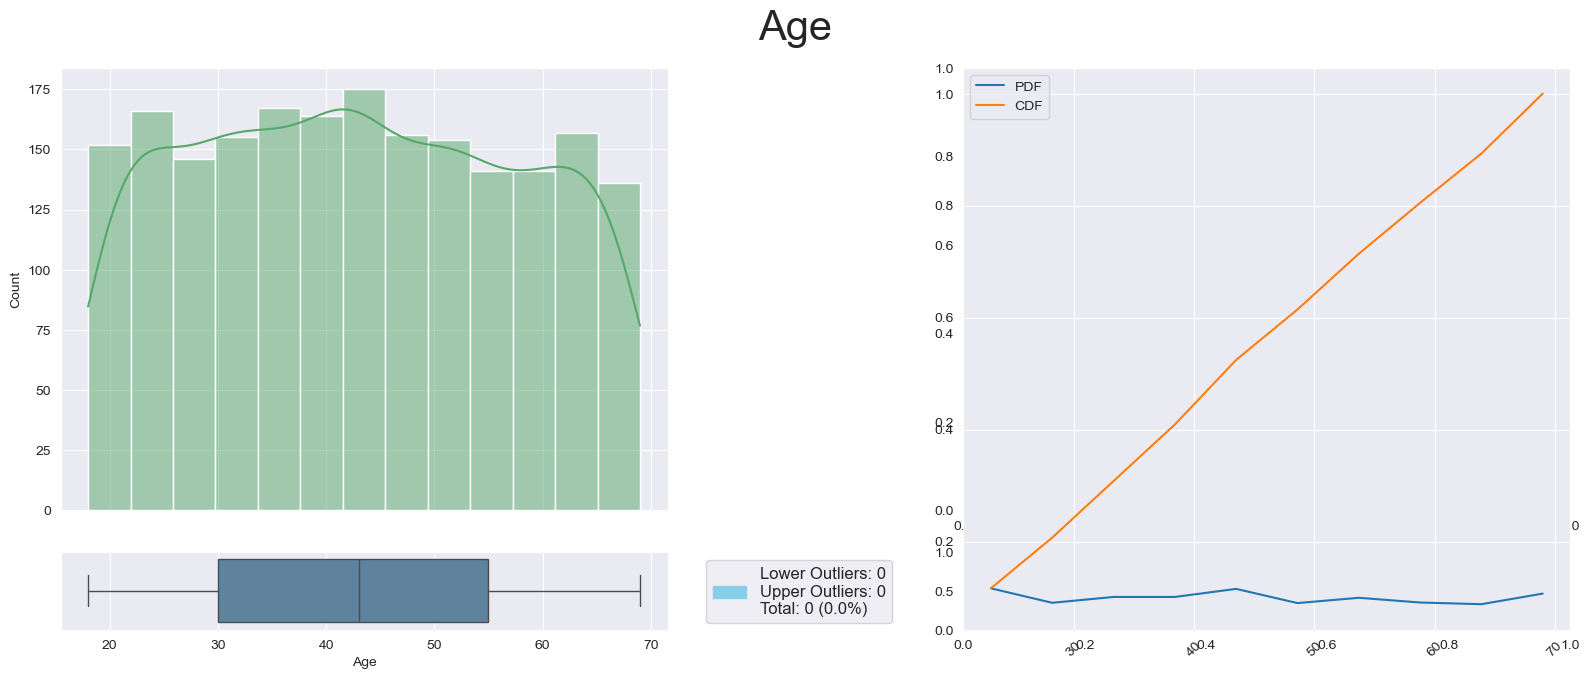

================== Age ==================
                             
count                  2010.0
mean                43.010448
std                 14.740003
min                      18.0
25%                      30.0
50%                      43.0
75%                      55.0
max                      69.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.04478
type     right(positive)-skew


In [285]:
describe_numerical_col(df, 'Age')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون Age</h2>
  <p>ستون <strong>Age</strong> نشان‌دهنده سن کاربران در مجموعه داده است و برای تحلیل‌های جمعیت‌شناسی و رفتار مصرف‌کننده اهمیت دارد. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۱۸ تا ۶۹ سال قرار دارند.</p>
  <p>میانگین و میانه برابرند (≈43) که به متعادل بودن توزیع اشاره دارد. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۴۴۷۸) وجود دارد، اما در عمل توزیع تقریباً متقارن است. نمودارهای PDF و CDF نیز روندی منظم و پیوسته دارند و فقط ۵ داده پرت در سمت بالا شناسایی شده‌اند.</p>
</div>

In [286]:
bins = [18, 30, 45, 60, 70]
bin_labels = ['Young', 'Adult', 'Middle-Aged', 'Old']
df = categorize_numerical_col(df, 'Age', bins=bins, bins_name=bin_labels)
describe_categorical_col(df, 'Age_categorized')

================== Age_categorized ==================
         Group  Count      %
0        Adult    619  31.31
1  Middle-Aged    558  28.22
2        Young    473  23.93
3          Old    327  16.54


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>Gender</h3>
</div>

In [287]:
describe_categorical_col(df, 'Gender')

================== Gender ==================
    Group  Count      %
0  Female   1223  60.85
1    Male    787  39.15


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون Gender</h2>
  <p>ستون <strong>Gender</strong> نشان‌دهنده جنسیت کاربران در مجموعه داده است و شامل دو گروه <strong>Female</strong> و <strong>Male</strong> می‌باشد. داده‌ها کامل و بدون مقدار گمشده‌اند.</p>
  <p>توزیع جنسیتی به‌صورت زیر است:</p>
  <ul>
    <li><strong>Female:</strong> ۱۲۲۳ نفر (۶۰.۸۵٪)</li>
    <li><strong>Male:</strong> ۷۸۷ نفر (۳۹.۱۵٪)</li>
  </ul>
  <p>این توزیع نشان می‌دهد که اکثریت کاربران در این مجموعه داده را زنان تشکیل می‌دهند.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>Income</h3>
</div>

null count : 79
null % : 3.9303%
مقادیر گمشده در Income با میانه پر شدند.


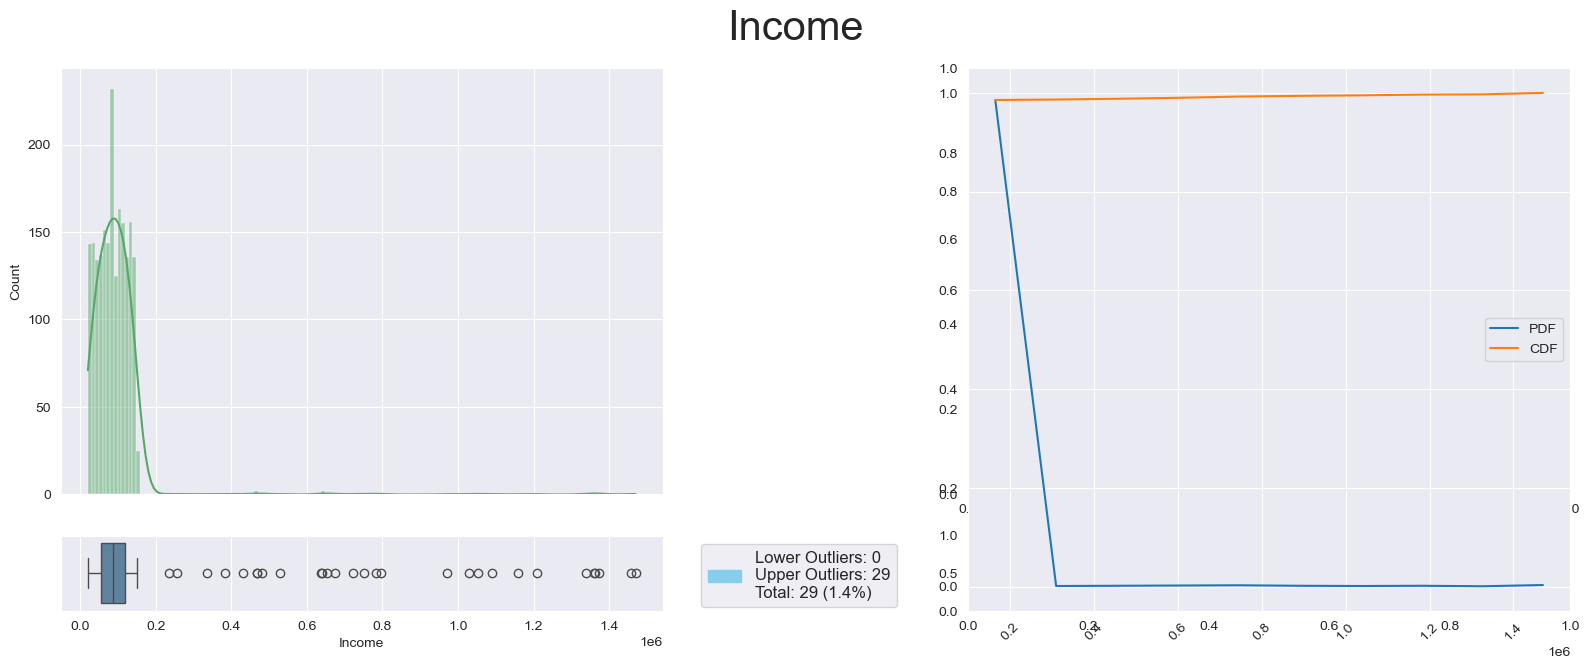

================== Income ==================
                             
count                  2010.0
mean             95933.934328
std             106571.274572
min                   20014.0
25%                  55001.25
50%                   86481.0
75%                  117053.0
max                 1470150.0
shapiro               0.00000
normal                  False
missing                     0
skew                  8.73299
type     right(positive)-skew


In [288]:
print(f"null count : {df['Income'].isna().sum()}")
print(f"null % : {(df['Income'].isna().sum() / len(df['Income']) * 100):.4f}%")
df["Income"] = df["Income"].fillna(df["Income"].median())
print("مقادیر گمشده در Income با میانه پر شدند.")
describe_numerical_col(df, 'Income')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون Income</h2>
  <p>ستون <strong>Income</strong> نشان‌دهنده میزان درآمد کاربران است و یکی از متغیرهای مهم در تحلیل رفتار مصرف‌کننده محسوب می‌شود. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بسیار گسترده از حدود ۲۰,۰۰۰ تا ۱,۴۷۰,۱۵۰ واحد قرار دارند.</p>
  <p>میانگین درآمد حدود ۹۵,۹۳۴ واحد است، اما انحراف معیار بسیار بالا (≈۱۰۶,۵۷۱) و چولگی شدید مثبت (۸.۷۳) نشان می‌دهد که توزیع درآمد به‌شدت نامتقارن و کشیده به سمت مقادیر بالا است. آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. نمودارهای PDF و CDF نیز تمرکز شدید داده‌ها در بخش پایین درآمد را نشان می‌دهند، و ۲۹ داده پرت در سمت بالا شناسایی شده‌اند (۱.۴٪).</p>
</div>

In [289]:
bins = pd.qcut(df['Income'], q=4, duplicates='drop', retbins=True)[1]
bin_labels = ['Low', 'Medium', 'High', 'Very High']
df = categorize_numerical_col(df, 'Income', bins=bins, bins_name=bin_labels)
describe_categorical_col(df, 'Income_categorized')

================== Income_categorized ==================
       Group  Count      %
0     Medium    542  26.98
1  Very High    503  25.04
2        Low    502  24.99
3       High    462  23.00


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>LoyaltyPoints</h3>
</div>

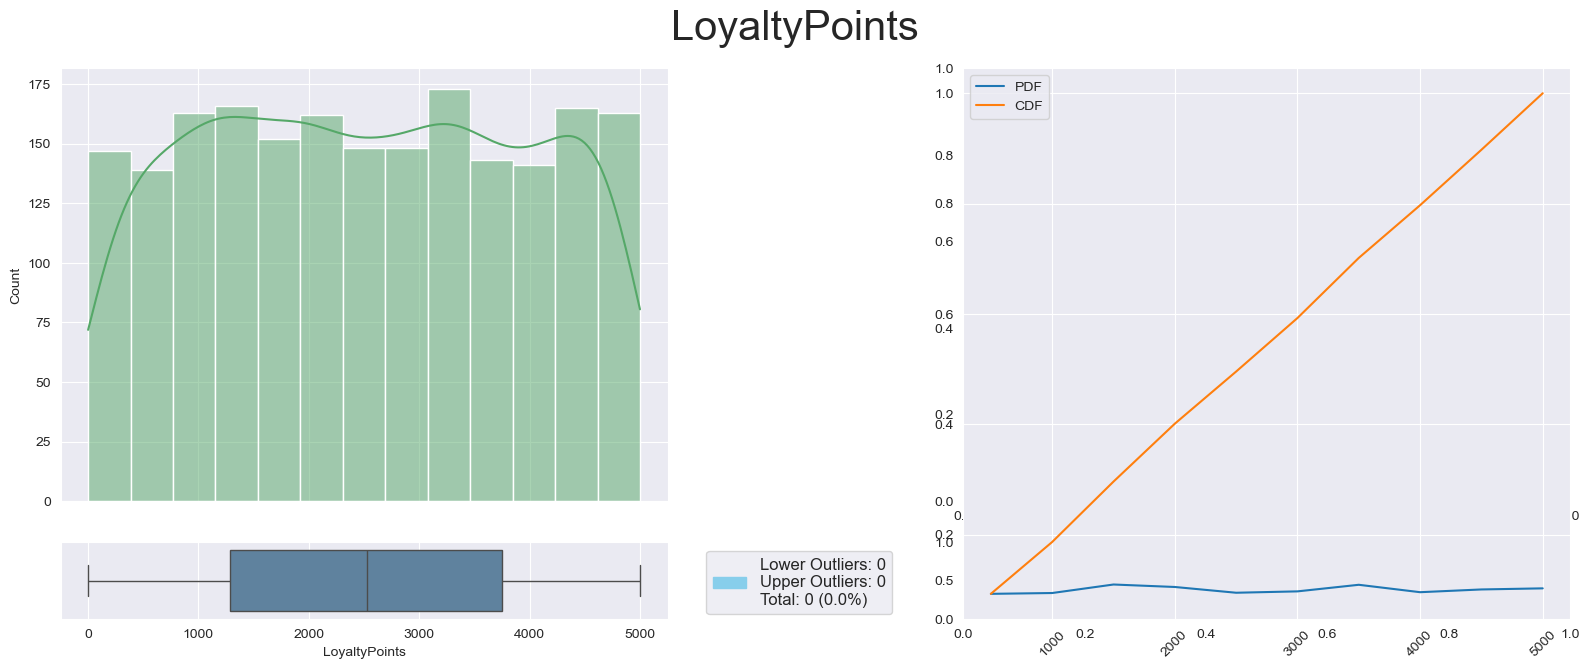

================== LoyaltyPoints ==================
                             
count                  2010.0
mean              2520.113433
std               1435.928358
min                       1.0
25%                    1287.0
50%                    2527.5
75%                    3752.0
max                    4999.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.00677
type     right(positive)-skew


In [290]:
describe_numerical_col(df, 'LoyaltyPoints')


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون LoyaltyPoints</h2>
  <p>ستون <strong>LoyaltyPoints</strong> نشان‌دهنده امتیاز وفاداری کاربران است و می‌تواند شاخصی برای میزان تعامل یا سابقه خرید آن‌ها باشد. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۱ تا ۴۹۹۹ واحد قرار دارند.</p>
  <p>میانگین و میانه تقریباً برابرند (≈۲۵۲۰)، که نشان‌دهنده توزیع متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۰۶۷۷) وجود دارد، اما در عمل توزیع تقریباً متقارن است. نمودارهای PDF و CDF نیز روندی منظم و پیوسته دارند و هیچ داده پرت شناسایی نشده است.</p>
  <p>در مجموع، توزیع LoyaltyPoints پایدار، متعادل و غیرنرمال است..</p>
</div>

In [291]:
bins = pd.qcut(df['LoyaltyPoints'], q=3, duplicates='drop', retbins=True)[1]
bin_labels = ['Low', 'Medium', 'High']
df = categorize_numerical_col(df, 'LoyaltyPoints', bins=bins, bins_name=bin_labels)
describe_categorical_col(df, 'LoyaltyPoints_categorized')

================== LoyaltyPoints_categorized ==================
    Group  Count      %
0  Medium    670  33.35
1    High    670  33.35
2     Low    669  33.30


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>Campaign Channel</h3>
</div>

In [292]:
describe_categorical_col(df, 'CampaignChannel')
print(f"null count : {df['CampaignChannel'].isna().sum()}")
print(f"null % : {(df['CampaignChannel'].isna().sum() / len(df['CampaignChannel']) * 100):.4f}%")

================== CampaignChannel ==================
          Group  Count      %
0           PPC    422  22.74
1      Referral    404  21.77
2  Social Media    343  18.48
3           SEO    334  18.00
4         Email    247  13.31
5         email    106   5.71
null count : 154
null % : 7.6617%


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون CampaignChannel</h2>
  <p>همانطور که می‌بینیم، Email و email دو گروه جداگانه هستند که اشتباه است و باید آنها را ادغام کنیم.و همچینین حدود 8 درصد مقادیر گمشده داریم که درصد کمی نیست به همین خاطر یک دسته جدید به نام other اضافه میکنیم و به انها اختصاص میدهیم</p>
</div>

In [293]:
df['CampaignChannel'] = df['CampaignChannel'].str.replace('email', 'Email')
df['CampaignChannel'] = df['CampaignChannel'].fillna('Other')
describe_categorical_col(df, 'CampaignChannel')

================== CampaignChannel ==================
          Group  Count      %
0           PPC    422  21.00
1      Referral    404  20.10
2         Email    353  17.56
3  Social Media    343  17.06
4           SEO    334  16.62
5         Other    154   7.66


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون CampaignChannel</h2>
  <p>ستون <strong>CampaignChannel</strong> نشان‌دهنده کانال‌های مختلف تبلیغاتی مورد استفاده در کمپین‌هاست. داده‌ها شامل ۶ گروه هستند که توزیع آن‌ها به‌صورت زیر است:</p>
  <ul>
    <li><strong>PPC:</strong> ۴۲۲ رکورد (۲۱.۰۰٪)</li>
    <li><strong>Referral:</strong> ۴۰۴ رکورد (۲۰.۱۰٪)</li>
    <li><strong>Email:</strong> ۳۵۳ رکورد (۱۷.۵۶٪)</li>
    <li><strong>Social Media:</strong> ۳۴۳ رکورد (۱۷.۰۶٪)</li>
    <li><strong>SEO:</strong> ۳۳۴ رکورد (۱۶.۶۲٪)</li>
    <li><strong>Other:</strong> ۱۵۴ رکورد (۷.۶۶٪)</li>
  </ul>
  <p>توزیع نسبتاً متعادل است و نشان‌دهنده استفاده متنوع از کانال‌های تبلیغاتی در کمپین‌هاست.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>CampaignType</h3>
</div>

In [294]:
describe_categorical_col(df, 'CampaignType')


================== CampaignType ==================
           Group  Count      %
0     Conversion    539  26.82
1  Consideration    502  24.98
2      Retention    490  24.38
3      Awareness    479  23.83


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون CampaignType</h2>
  <p>ستون <strong>CampaignType</strong> نشان‌دهنده نوع کمپین‌های تبلیغاتی اجرا شده برای کاربران است. داده‌ها شامل ۴ گروه هستند که توزیع آن‌ها به‌صورت زیر است:</p>
  <ul>
    <li><strong>Conversion:</strong> ۵۳۹ رکورد (۲۶.۸۲٪)</li>
    <li><strong>Consideration:</strong> ۵۰۲ رکورد (۲۴.۹۸٪)</li>
    <li><strong>Retention:</strong> ۴۹۰ رکورد (۲۴.۳۸٪)</li>
    <li><strong>Awareness:</strong> ۴۷۹ رکورد (۲۳.۸۳٪)</li>
  </ul>
  <p>توزیع بسیار متعادل است و هیچ نوع کمپینی به‌طور غالب بر سایرین برتری ندارد..</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>AdvertisingPlatform</h3>
</div>

In [295]:
describe_categorical_col(df, 'AdvertisingPlatform')


================== AdvertisingPlatform ==================
      Group  Count      %
0  IsConfid   2010  100.0


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون AdvertisingPlatform</h2>
  <p>ستون <strong>AdvertisingPlatform</strong> نشان‌دهنده پلتفرم تبلیغاتی مورد استفاده در کمپین‌هاست. در این مجموعه داده، تمام رکوردها (۱۰۰٪) به گروه <strong>IsConfid</strong> تعلق دارند.</p>
  <p>این یکنواختی نشان می‌دهد که هیچ تنوعی در پلتفرم‌های تبلیغاتی وجود ندارد و تمام کمپین‌ها از یک منبع تبلیغاتی واحد استفاده کرده‌اند..</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>AdvertisingTool</h3>
</div>

In [296]:
describe_categorical_col(df, 'AdvertisingTool')

================== AdvertisingTool ==================
        Group  Count      %
0  ToolConfid   2010  100.0


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون AdvertisingTool</h2>
  <p>ستون <strong>AdvertisingTool</strong> نشان‌دهنده ابزار تبلیغاتی مورد استفاده در کمپین‌هاست. در این مجموعه داده، تمام رکوردها (۱۰۰٪) به گروه <strong>ToolConfid</strong> تعلق دارند.</p>
  <p>این یکنواختی نشان می‌دهد که هیچ تنوعی در ابزارهای تبلیغاتی وجود ندارد و تمام کمپین‌ها از یک ابزار واحد استفاده کرده‌اند.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>WebsiteVisits</h3>
</div>

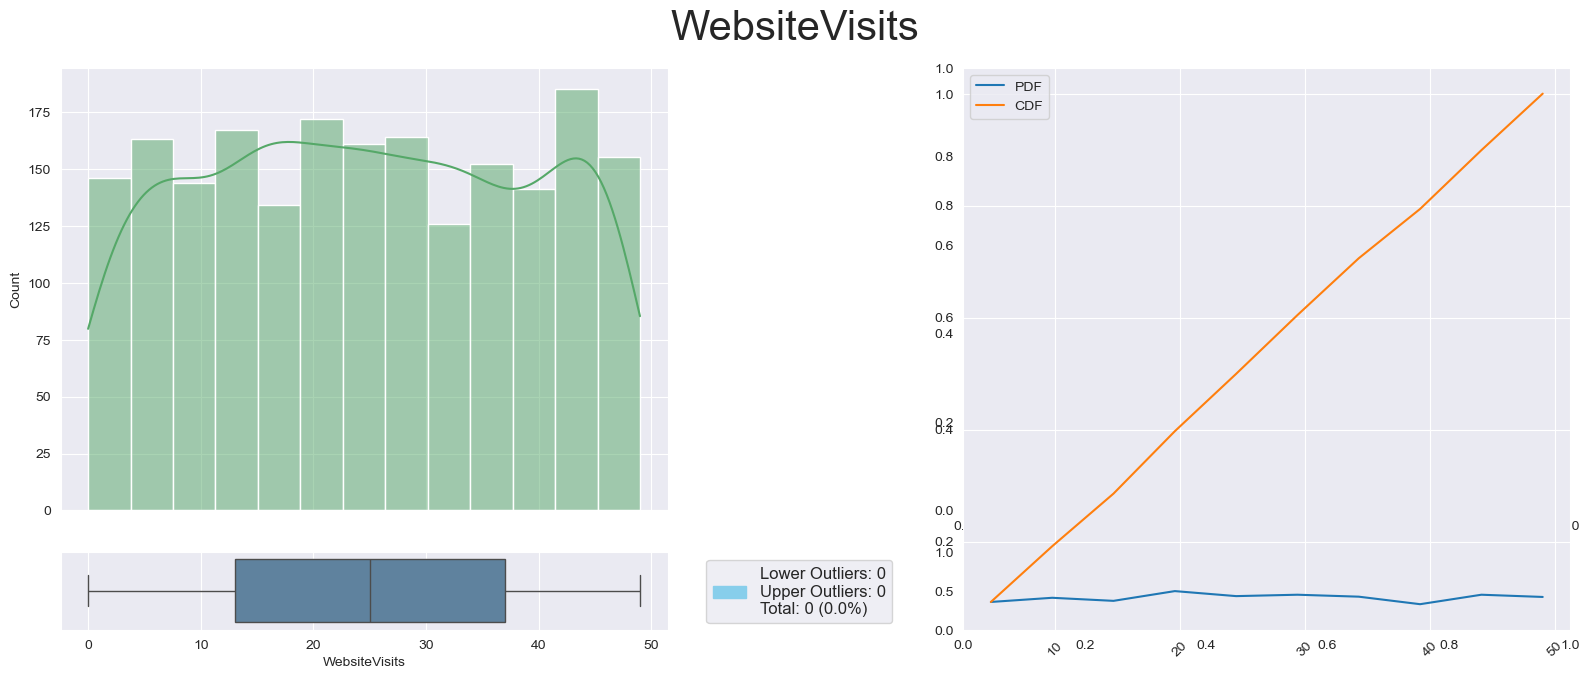

================== WebsiteVisits ==================
                             
count                  2010.0
mean                24.638806
std                 14.275219
min                       0.0
25%                      13.0
50%                      25.0
75%                      37.0
max                      49.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.00219
type     right(positive)-skew


In [297]:
describe_numerical_col(df, 'WebsiteVisits')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون WebsiteVisits</h2>
  <p>ستون <strong>WebsiteVisits</strong> نشان‌دهنده تعداد بازدیدهای کاربران از وب‌سایت است و می‌تواند شاخصی برای میزان تعامل اولیه با کمپین‌ها باشد. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۰ تا ۴۹ بازدید قرار دارند.</p>
  <p>میانگین و میانه تقریباً برابرند (≈۲۵)، که نشان‌دهنده توزیع متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۰۲۱۹) وجود دارد، اما در عمل توزیع تقریباً متقارن است. نمودارهای PDF و CDF نیز روندی منظم و پیوسته دارند و هیچ داده پرت شناسایی نشده است.</p>
  <p>در مجموع، توزیع WebsiteVisits پایدار، متعادل و غیرنرمال است.</p>
</div>

In [298]:
bins_WebsiteVisits = [0, 25, 50]
bin_labels_WebsiteVisits = ['Low', 'High']
df = categorize_numerical_col(df, 'WebsiteVisits', bins_WebsiteVisits, bin_labels_WebsiteVisits)
describe_categorical_col(df, 'WebsiteVisits_categorized')


================== WebsiteVisits_categorized ==================
  Group  Count     %
0   Low   1013  51.5
1  High    954  48.5


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>PagesPerVisit</h3>
</div>

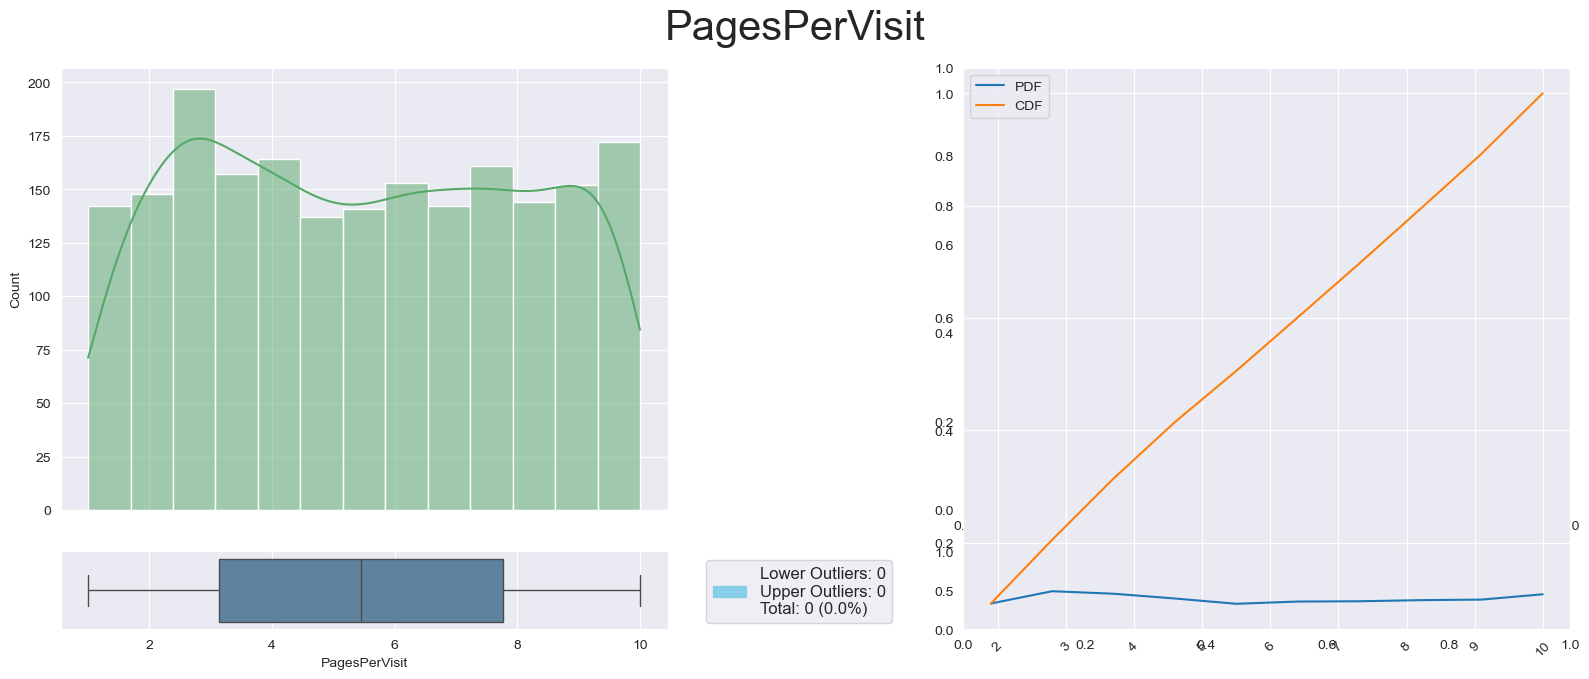

================== PagesPerVisit ==================
                             
count                  2010.0
mean                   5.4925
std                  2.620329
min                  1.001882
25%                  3.134389
50%                  5.446222
75%                  7.758085
max                  9.997134
shapiro               0.00000
normal                  False
missing                     0
skew                  0.04437
type     right(positive)-skew


In [299]:
describe_numerical_col(df, 'PagesPerVisit')


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون PagesPerVisit</h2>
  <p>ستون <strong>PagesPerVisit</strong> نشان‌دهنده میانگین تعداد صفحات بازدیدشده توسط هر کاربر در یک جلسه است و شاخصی مهم برای سنجش عمق تعامل کاربران با وب‌سایت محسوب می‌شود. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین حدود ۱ تا ۱۰ صفحه قرار دارند.</p>
  <p>میانگین و میانه بسیار نزدیک‌اند (≈۵.۵)، که نشان‌دهنده توزیع متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۴۴۳۷) وجود دارد، اما در عمل توزیع تقریباً متقارن است. نمودارهای PDF و CDF نیز روندی منظم و پیوسته دارند .</p>
  <p>در مجموع، توزیع PagesPerVisit پایدار، متعادل و غیرنرمال است. </p>
</div>

In [300]:
bins = [0, 5, 10]
bin_labels = ['Low', 'High']
df = categorize_numerical_col(df, 'PagesPerVisit', bins=bins, bins_name=bin_labels)
describe_categorical_col(df, 'PagesPerVisit_categorized')

================== PagesPerVisit_categorized ==================
  Group  Count      %
0  High   1097  54.58
1   Low    913  45.42


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>TimeOnSite</h3>
</div>

null count : 79
null % : 3.9303%


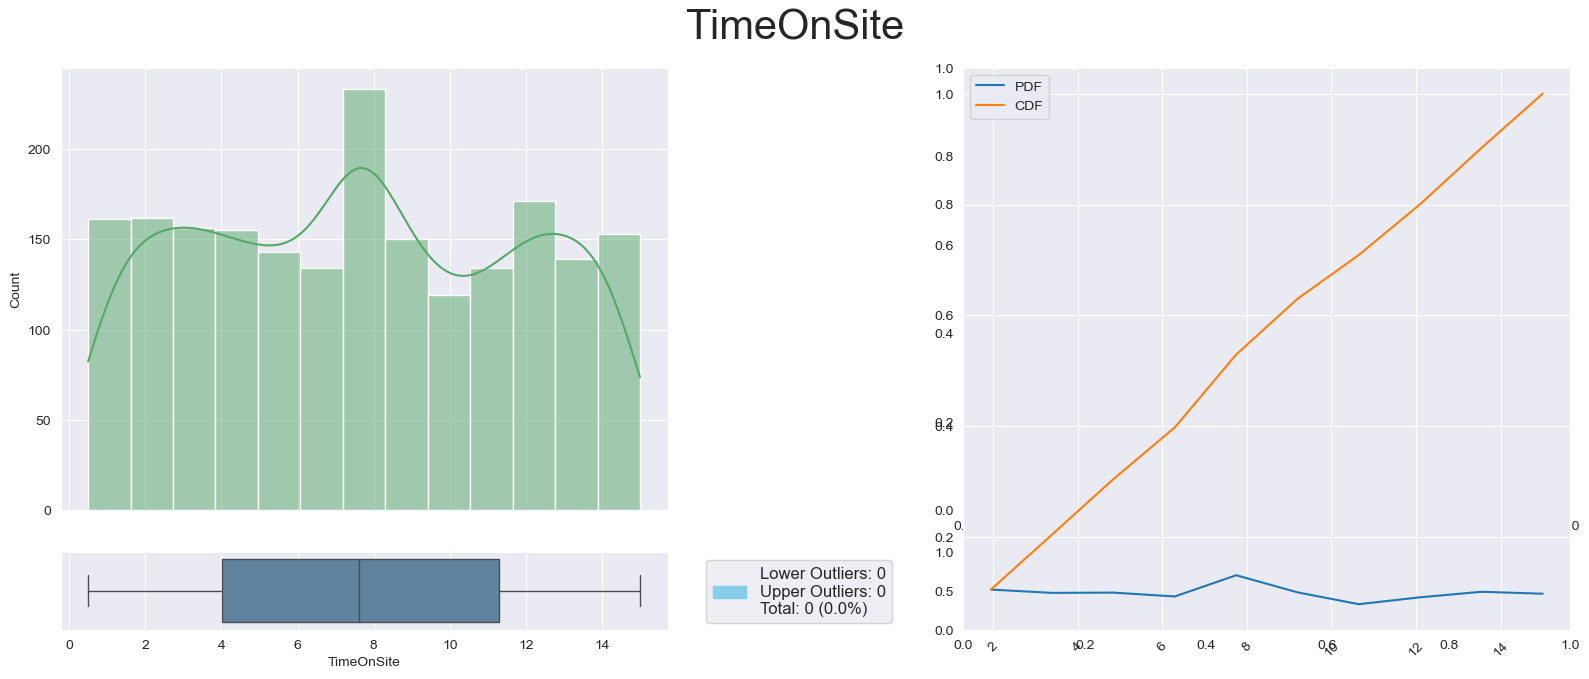

================== TimeOnSite ==================
                             
count                  2010.0
mean                 7.624579
std                  4.169409
min                  0.501684
25%                  4.020522
50%                  7.624579
75%                 11.296214
max                 14.992795
shapiro               0.00000
normal                  False
missing                     0
skew                  0.03591
type     right(positive)-skew


In [301]:
print(f"null count : {df['TimeOnSite'].isna().sum()}")
print(f"null % : {(df['TimeOnSite'].isna().sum() / len(df['TimeOnSite']) * 100):.4f}%")
df["TimeOnSite"] = df["TimeOnSite"].fillna(df["TimeOnSite"].mean())
describe_numerical_col(df, 'TimeOnSite')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون TimeOnSite</h2>
  <p>ستون <strong>TimeOnSite</strong> نشان‌دهنده مدت‌زمان حضور کاربران در وب‌سایت است و شاخصی مهم برای سنجش میزان تعامل و علاقه‌مندی کاربران محسوب می‌شود. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین حدود ۰.۵ تا ۱۵ دقیقه قرار دارند.</p>
  <p>میانگین و میانه برابرند (≈۷.۶)، که نشان‌دهنده توزیع متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۳۵۹۱) وجود دارد، اما در عمل توزیع تقریباً متقارن است. نمودارهای PDF و CDF نیز روندی منظم و پیوسته دارند.</p>
  <p>در مجموع، توزیع TimeOnSite پایدار، متعادل و غیرنرمال است.</p>
</div>

In [302]:
bins = [0, 7, 15]
bin_labels = ['Low', 'High']
df = categorize_numerical_col(df, 'TimeOnSite', bins=bins, bins_name=bin_labels)
describe_categorical_col(df, 'TimeOnSite_categorized')

================== TimeOnSite_categorized ==================
  Group  Count      %
0  High   1122  55.82
1   Low    888  44.18


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>EmailOpens</h3>
</div>

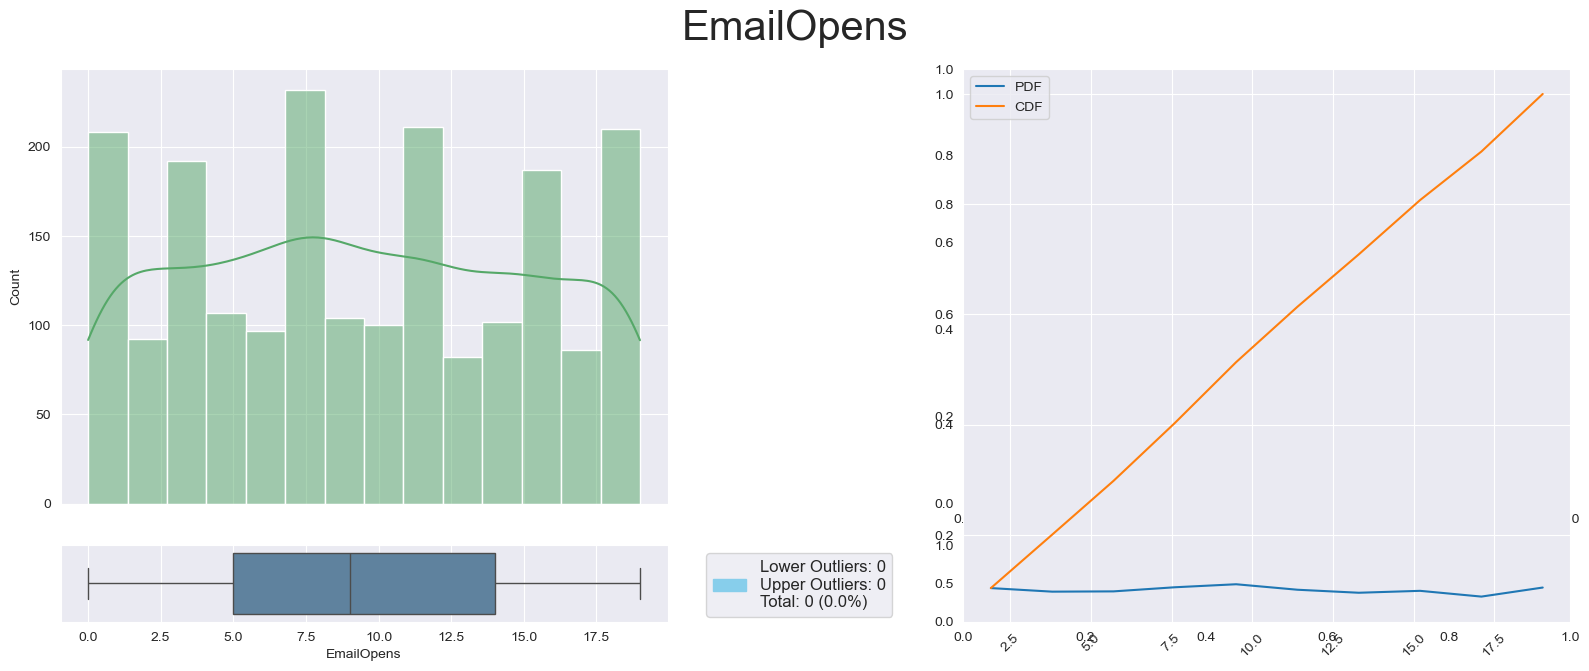

================== EmailOpens ==================
                             
count                  2010.0
mean                 9.410945
std                  5.740643
min                       0.0
25%                       5.0
50%                       9.0
75%                      14.0
max                      19.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.03556
type     right(positive)-skew


In [303]:
 describe_numerical_col(df, "EmailOpens")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون EmailOpens</h2>
  <p>ستون <strong>EmailOpens</strong> نشان‌دهنده تعداد دفعاتی است که کاربران ایمیل‌های تبلیغاتی را باز کرده‌اند. این متغیر شاخصی مهم برای سنجش میزان تعامل کاربران با کمپین‌های ایمیلی محسوب می‌شود. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۰ تا ۱۹ بار باز کردن ایمیل قرار دارند.</p>
  <p>میانگین و میانه بسیار نزدیک‌اند (≈۹)، که نشان‌دهنده توزیع متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۳۵۵۶) وجود دارد، اما در عمل توزیع تقریباً متقارن است. نمودارهای PDF و CDF نیز روندی منظم و پیوسته دارند و هیچ داده پرت شناسایی نشده است.</p>
  <p>در مجموع، توزیع EmailOpens پایدار، متعادل و غیرنرمال است. </p>
</div>

In [304]:
bins_EmailOpens = [0, 5, 10, 15, 20]
bins_labels_EmailOpens = ["Very Low", "Low", "Medium", "High"]
df = categorize_numerical_col(df, "EmailOpens", bins_EmailOpens, bins_labels_EmailOpens)
describe_categorical_col(df, 'EmailOpens_categorized')


================== EmailOpens_categorized ==================
      Group  Count      %
0       Low    533  27.99
1  Very Low    493  25.89
2    Medium    491  25.79
3      High    387  20.33


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>EmailClicks</h3>
</div>

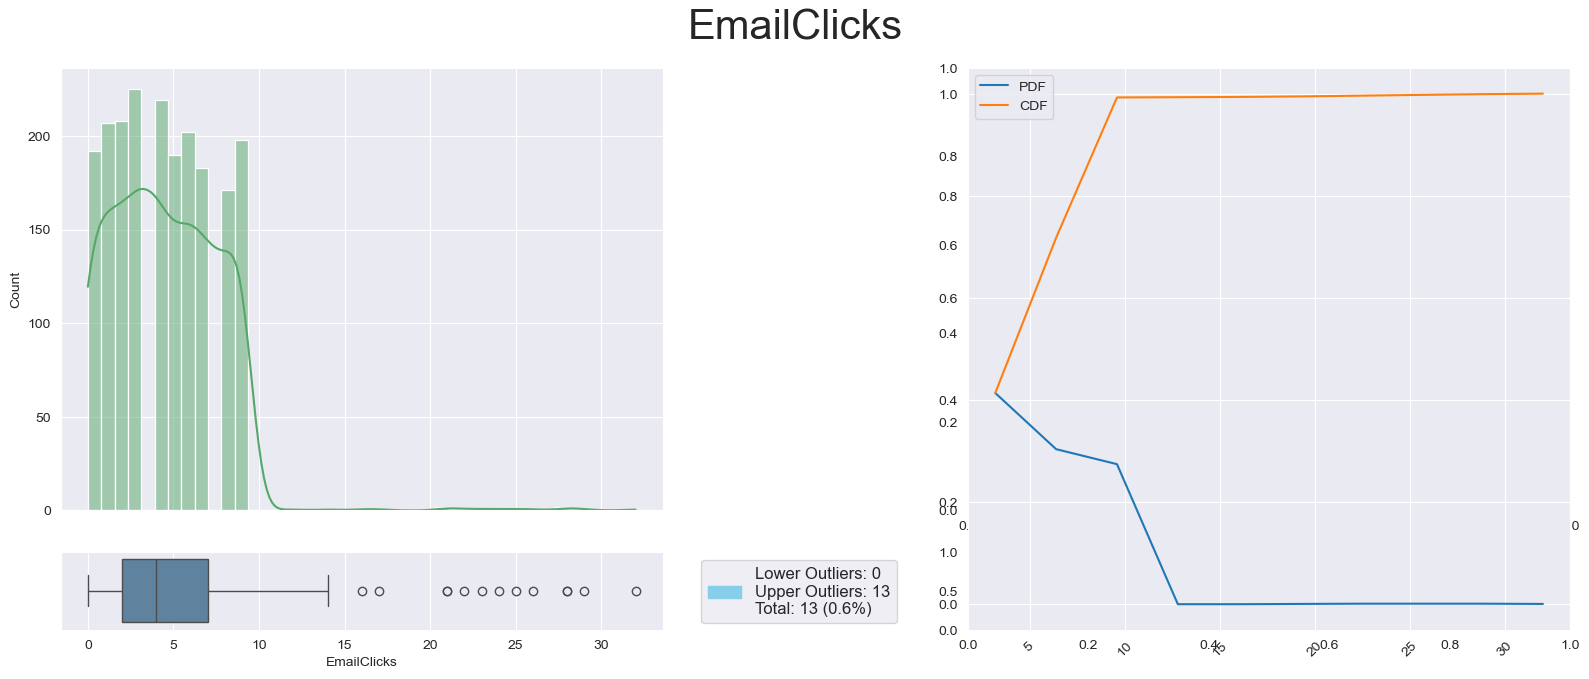

================== EmailClicks ==================
                             
count                  2010.0
mean                 4.529851
std                  3.262584
min                       0.0
25%                       2.0
50%                       4.0
75%                       7.0
max                      32.0
shapiro               0.00000
normal                  False
missing                     0
skew                  1.56944
type     right(positive)-skew


In [305]:
 describe_numerical_col(df, "EmailClicks")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون EmailClicks</h2>
  <p>ستون <strong>EmailClicks</strong> نشان‌دهنده تعداد دفعاتی است که کاربران روی لینک‌های موجود در ایمیل‌های تبلیغاتی کلیک کرده‌اند. این متغیر شاخصی مهم برای سنجش اثربخشی کمپین‌های ایمیلی و میزان تعامل کاربران با محتوای ارسال‌شده محسوب می‌شود.</p>
  <p>داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۰ تا ۳۲ کلیک قرار دارند. میانگین برابر با ۴.۵ و میانه برابر با ۴ است، که نشان‌دهنده تمرکز داده‌ها در محدوده پایین‌تر است. آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت قابل توجهی (۱.۵۶۹۴۴) وجود دارد، که نشان‌دهنده وجود تعداد کمی از کاربران با کلیک‌های بسیار بالا است. نمودارهای PDF و CDF نیز این عدم تقارن را تأیید می‌کنند. همچنین ۱۳ داده پرت در سمت بالا شناسایی شده‌اند (۰.۶٪).</p>
  <p>در مجموع، توزیع EmailClicks غیرنرمال و با چولگی مثبت است.</p>
</div>

In [306]:
bins_EmailClicks = [0, 3, 6, float("inf")]
bins_labels_EmailClicks = ["Low", "Medium", "High"]
df = categorize_numerical_col(df, "EmailClicks", bins_EmailClicks, bins_labels_EmailClicks)
describe_categorical_col(df, 'EmailClicks_categorized')


================== EmailClicks_categorized ==================
    Group  Count      %
0     Low    640  35.20
1  Medium    611  33.61
2    High    567  31.19


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>SocialShares</h3>
</div>

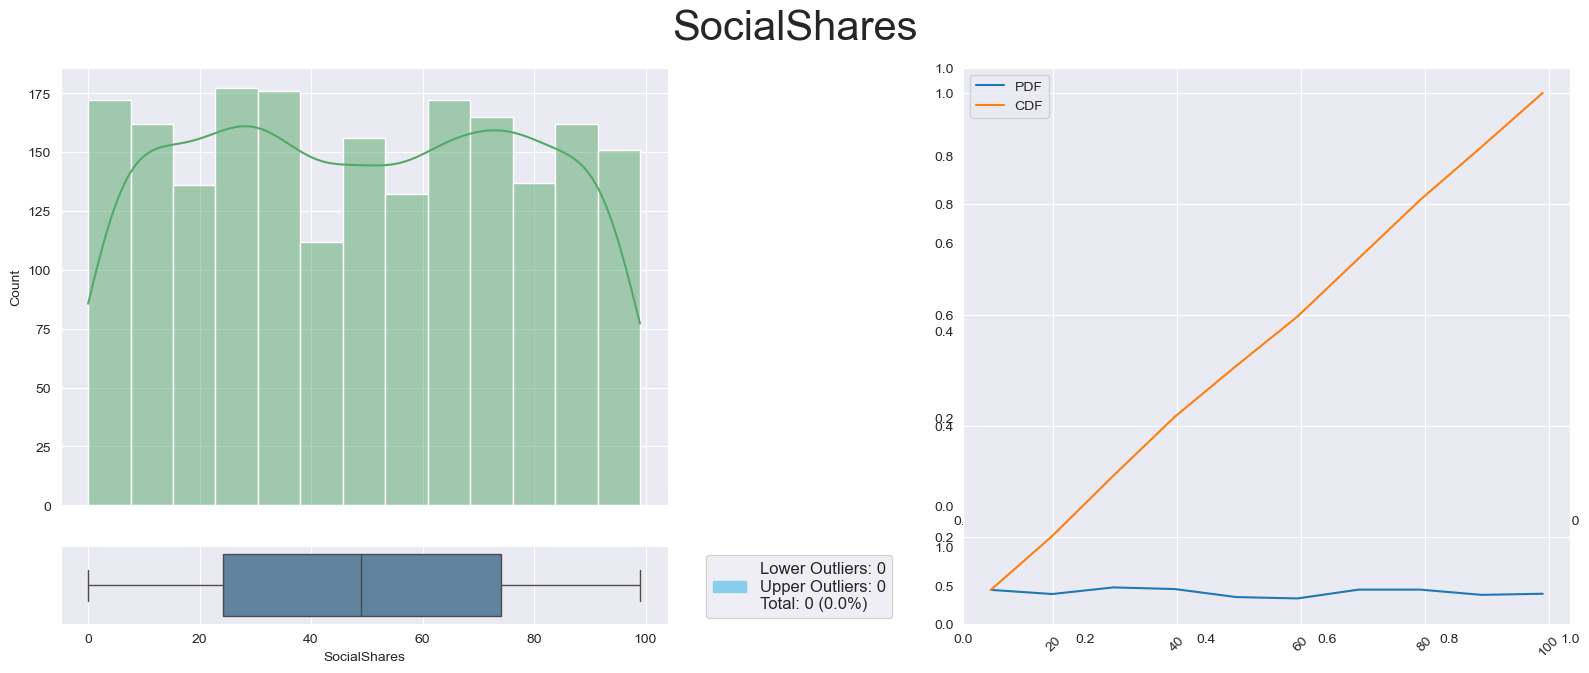

================== SocialShares ==================
                             
count                  2010.0
mean                49.002985
std                 28.960985
min                       0.0
25%                     24.25
50%                      49.0
75%                      74.0
max                      99.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.00676
type     right(positive)-skew


In [307]:
 describe_numerical_col(df, "SocialShares")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون SocialShares</h2>
  <p>ستون <strong>SocialShares</strong> نشان‌دهنده تعداد دفعاتی است که محتوای کمپین توسط کاربران در شبکه‌های اجتماعی به اشتراک گذاشته شده است. این متغیر شاخصی مهم برای سنجش میزان علاقه‌مندی، تعامل اجتماعی و قابلیت وایرال شدن کمپین‌ها محسوب می‌شود.</p>
  <p>داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۰ تا ۹۹ اشتراک‌گذاری قرار دارند. میانگین و میانه برابرند (≈۴۹)، که نشان‌دهنده توزیع متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۰۶۷۶) وجود دارد، اما در عمل توزیع تقریباً متقارن است. نمودارهای PDF و CDF نیز این تعادل را تأیید می‌کنند و هیچ داده پرت شناسایی نشده است.</p>
  <p>در مجموع، توزیع SocialShares پایدار، متعادل و غیرنرمال است. </p>
</div>

In [308]:
bins_SocialShares = [0, 25, 50, 75, 100]
bins_labels_SocialShares = ["Very Low", "Low", "Medium", "High"]
df = categorize_numerical_col(df, "SocialShares", bins_SocialShares, bins_labels_SocialShares)
describe_categorical_col(df, 'SocialShares_categorized')


================== SocialShares_categorized ==================
      Group  Count      %
0       Low    509  25.71
1  Very Low    505  25.51
2    Medium    490  24.75
3      High    476  24.04


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>AdSpend</h3>
</div>

In [309]:
#تبدیل ستون به تایپ عددی و اصلاح داده ها
df['AdSpend'] = df['AdSpend'].astype(str).str.replace(r'[^\d\.]', '', regex=True).astype(float)

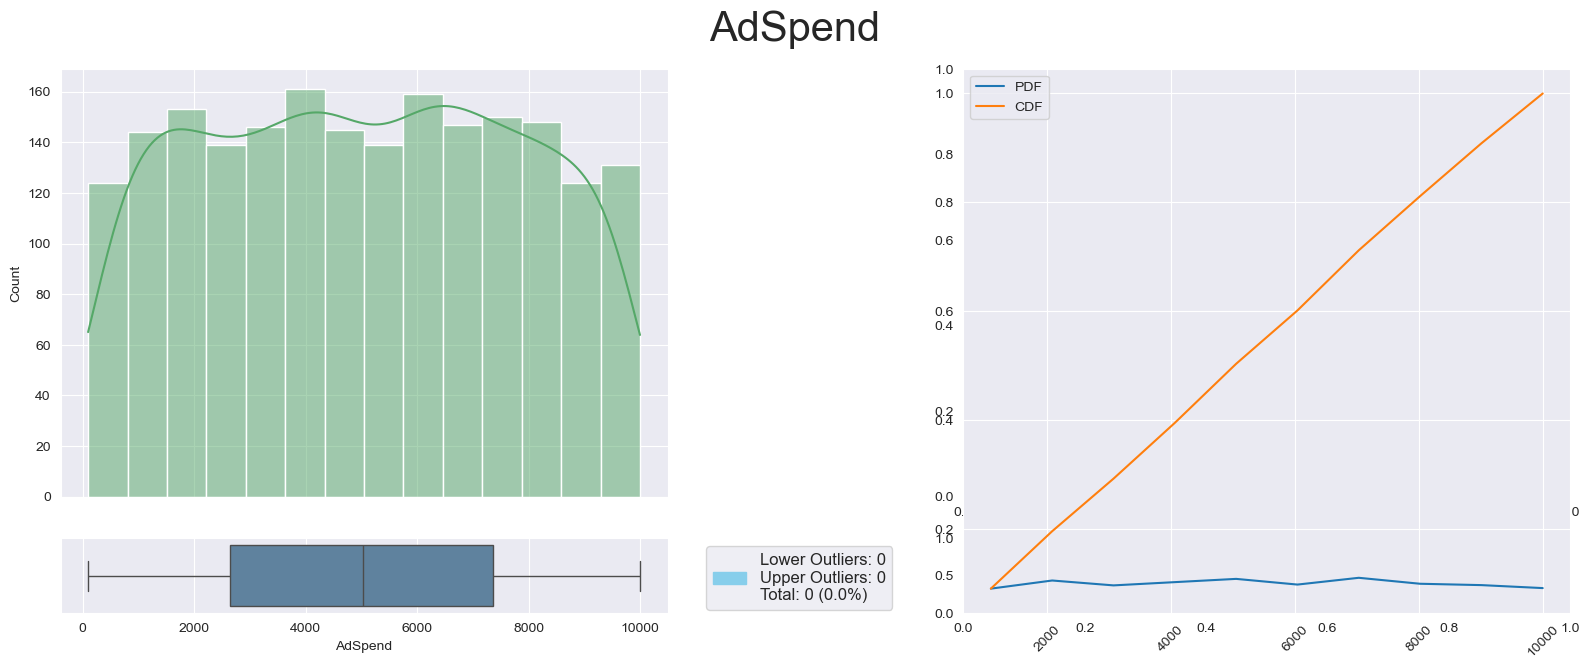

================== AdSpend ==================
                             
count                  2010.0
mean              5028.022186
std                2788.01034
min                100.668227
25%               2639.654462
50%               5023.946852
75%               7362.637876
max               9997.347635
shapiro               0.00000
normal                  False
missing                     0
skew                  0.00315
type     right(positive)-skew


In [310]:
describe_numerical_col(df, 'AdSpend')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون AdSpend</h2>
  <p>ستون <strong>AdSpend</strong> نشان‌دهنده میزان هزینه تبلیغات برای هر رکورد است و یکی از متغیرهای کلیدی در تحلیل بازاریابی محسوب می‌شود. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای نسبتاً گسترده از حدود ۱۰۰ تا ۱۰,۰۰۰ واحد قرار دارند.</p>
  <p>میانگین و میانه بسیار نزدیک‌اند که به ظاهر متقارن بودن توزیع اشاره دارد. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۰۳۱۵) وجود دارد، اما در عمل توزیع تقریباً متقارن است. منحنی‌های PDF و CDF نیز شکل منظم و پیوسته‌ای دارند و هیچ نقطه پرت شناسایی نشده است.</p>
  <p>در مجموع، توزیع AdSpend پایدار، متعادل و غیرنرمال است.</p>
</div>

In [311]:
bins_AdSpend = [0, 2500, 5000, 7500, 10000]
bin_labels_AdSpend = ['Very Low Budget', 'Low Budget', 'Medium Budget', 'High Budget']
df = categorize_numerical_col(df, 'AdSpend', bins_AdSpend, bin_labels_AdSpend)
describe_categorical_col(df, 'AdSpend_categorized')

================== AdSpend_categorized ==================
             Group  Count      %
0    Medium Budget    538  26.77
1       Low Budget    519  25.82
2  Very Low Budget    481  23.93
3      High Budget    472  23.48


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>ClickThroughRate</h3>
</div>

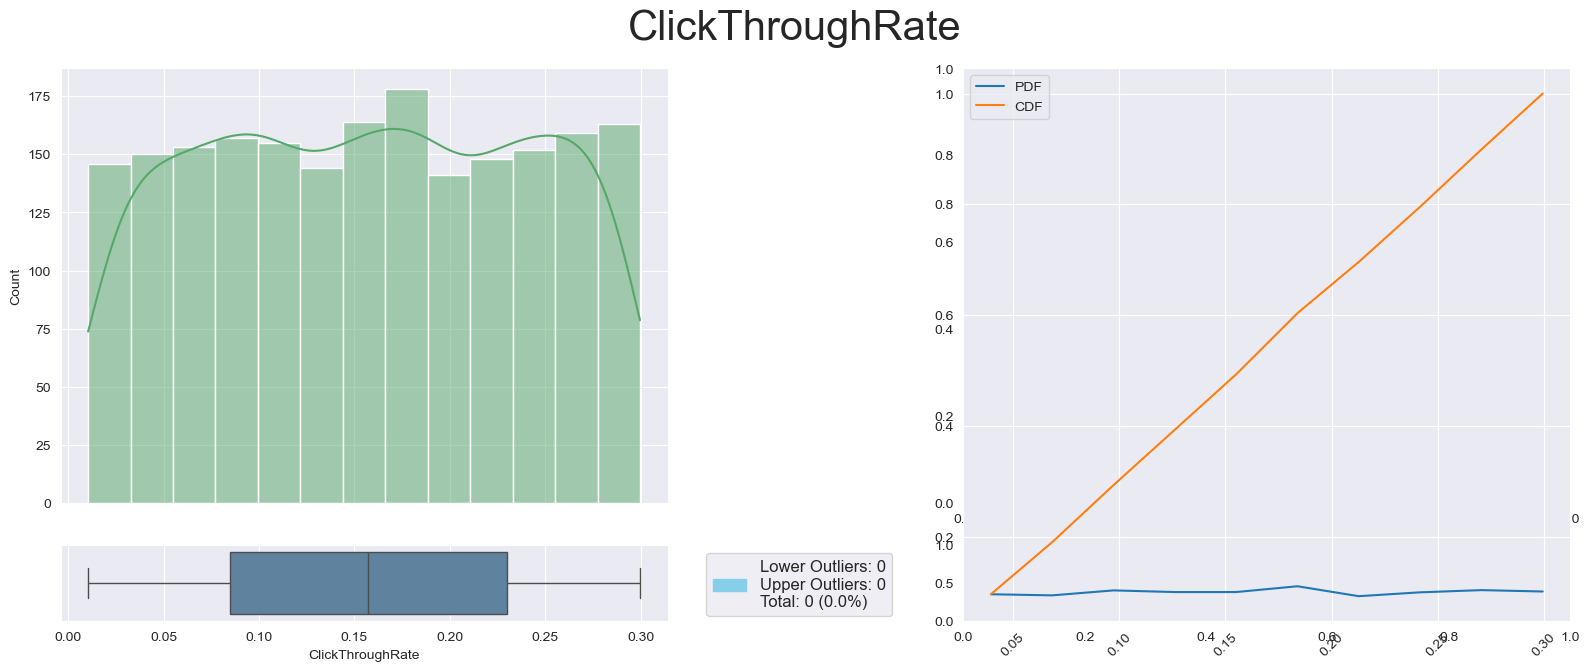

================== ClickThroughRate ==================
                            
count                 2010.0
mean                0.156358
std                 0.083178
min                 0.010514
25%                 0.084726
50%                 0.156852
75%                 0.229806
max                 0.299557
shapiro              0.00000
normal                 False
missing                    0
skew                -0.01158
type     left(negative)-skew


In [312]:
describe_numerical_col(df, "ClickThroughRate")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون ClickThroughRate</h2>
  <p>ستون <strong>ClickThroughRate</strong> نشان‌دهنده نرخ کلیک کاربران بر روی لینک‌های تبلیغاتی نسبت به تعداد نمایش آن‌هاست. این متغیر یکی از شاخص‌های کلیدی در ارزیابی اثربخشی کمپین‌های دیجیتال مارکتینگ محسوب می‌شود.</p>
  <p>داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۰.۰۱ تا ۰.۳۰ قرار دارند. میانگین و میانه بسیار نزدیک‌اند (≈۰.۱۵۶)، که نشان‌دهنده توزیع متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی منفی بسیار جزئی (−۰.۰۱۱۵۸) وجود دارد، که نشان‌دهنده تمایل اندکی به سمت مقادیر بالاتر است. نمودارهای PDF و CDF نیز این تعادل نسبی را تأیید می‌کنند.</p>
  <p>در مجموع، توزیع ClickThroughRate پایدار، متعادل و غیرنرمال است.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>ConversionRate</h3>
</div>

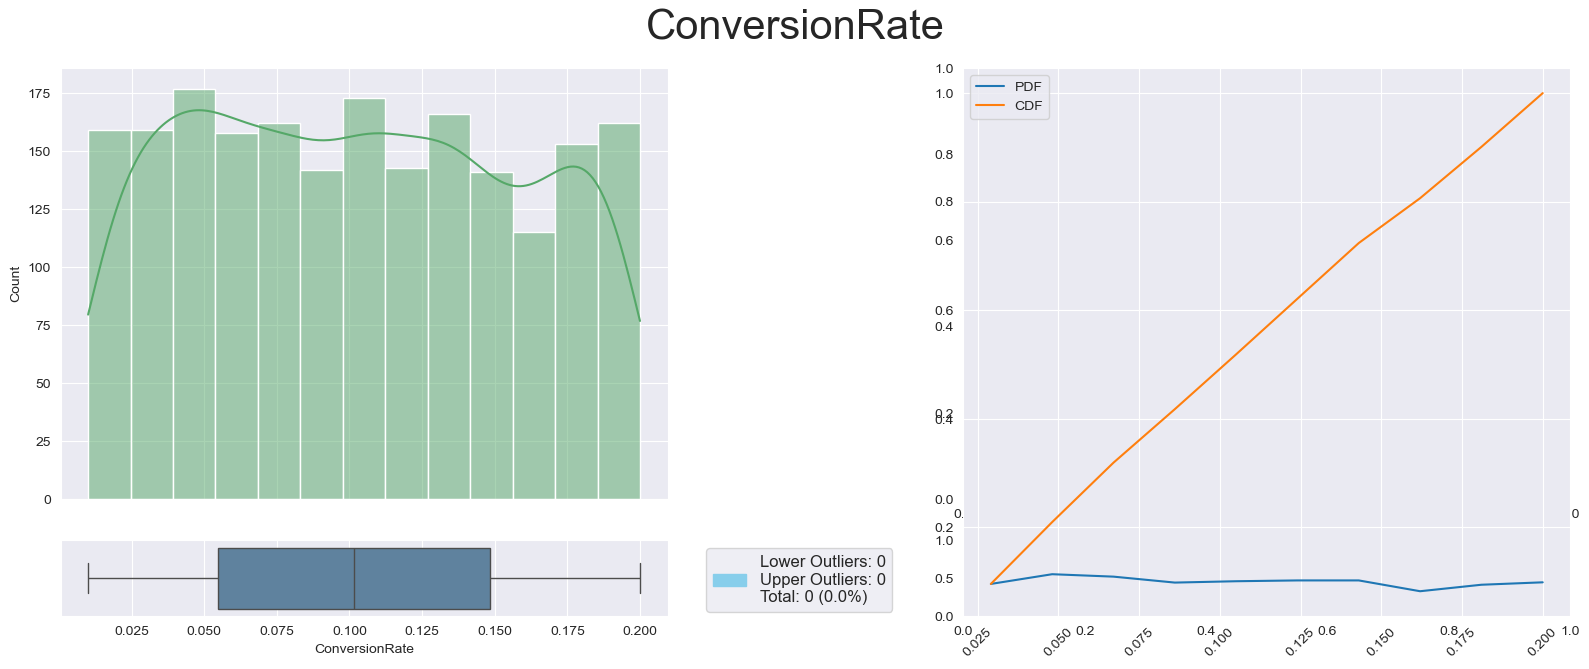

================== ConversionRate ==================
                             
count                  2010.0
mean                 0.102761
std                  0.054845
min                  0.010059
25%                   0.05468
50%                  0.101575
75%                  0.148428
max                  0.199995
shapiro               0.00000
normal                  False
missing                     0
skew                  0.07278
type     right(positive)-skew


In [313]:
describe_numerical_col(df, "ConversionRate")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون ConversionRate</h2>
  <p>ستون <strong>ConversionRate</strong> نشان‌دهنده نرخ تبدیل کاربران است؛ یعنی نسبت کاربرانی که پس از تعامل با کمپین، اقدام مطلوبی مانند خرید، ثبت‌نام یا دانلود انجام داده‌اند. این متغیر یکی از مهم‌ترین شاخص‌های عملکرد کمپین‌های دیجیتال مارکتینگ محسوب می‌شود.</p>
  <p>داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۰.۰۱ تا ۰.۲۰ قرار دارند. میانگین و میانه بسیار نزدیک‌اند (≈۰.۱۰)، که نشان‌دهنده توزیع متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی مثبت بسیار جزئی (۰.۰۷۲۷۸) وجود دارد، که نشان‌دهنده تمایل اندکی به سمت مقادیر بالاتر است. نمودارهای PDF و CDF نیز این تعادل نسبی را تأیید می‌کنند و هیچ داده پرت شناسایی نشده است.</p>
  <p>در مجموع، توزیع ConversionRate پایدار، متعادل و غیرنرمال است.</p>
</div>

In [314]:
bins_ConversionRate = [0, 0.05, 0.10, 0.15, 0.20]
bin_labels_ConversionRate = ['Very Low Conversion', 'Low Conversion', 'Moderate Conversion', 'High Conversion']
df = categorize_numerical_col(df, 'ConversionRate', bins_ConversionRate, bin_labels_ConversionRate)
describe_categorical_col(df, "ConversionRate_categorized")

================== ConversionRate_categorized ==================
                 Group  Count      %
0  Moderate Conversion    540  26.87
1       Low Conversion    539  26.82
2      High Conversion    489  24.33
3  Very Low Conversion    442  21.99


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>PreviousPurchases</h3>
</div>

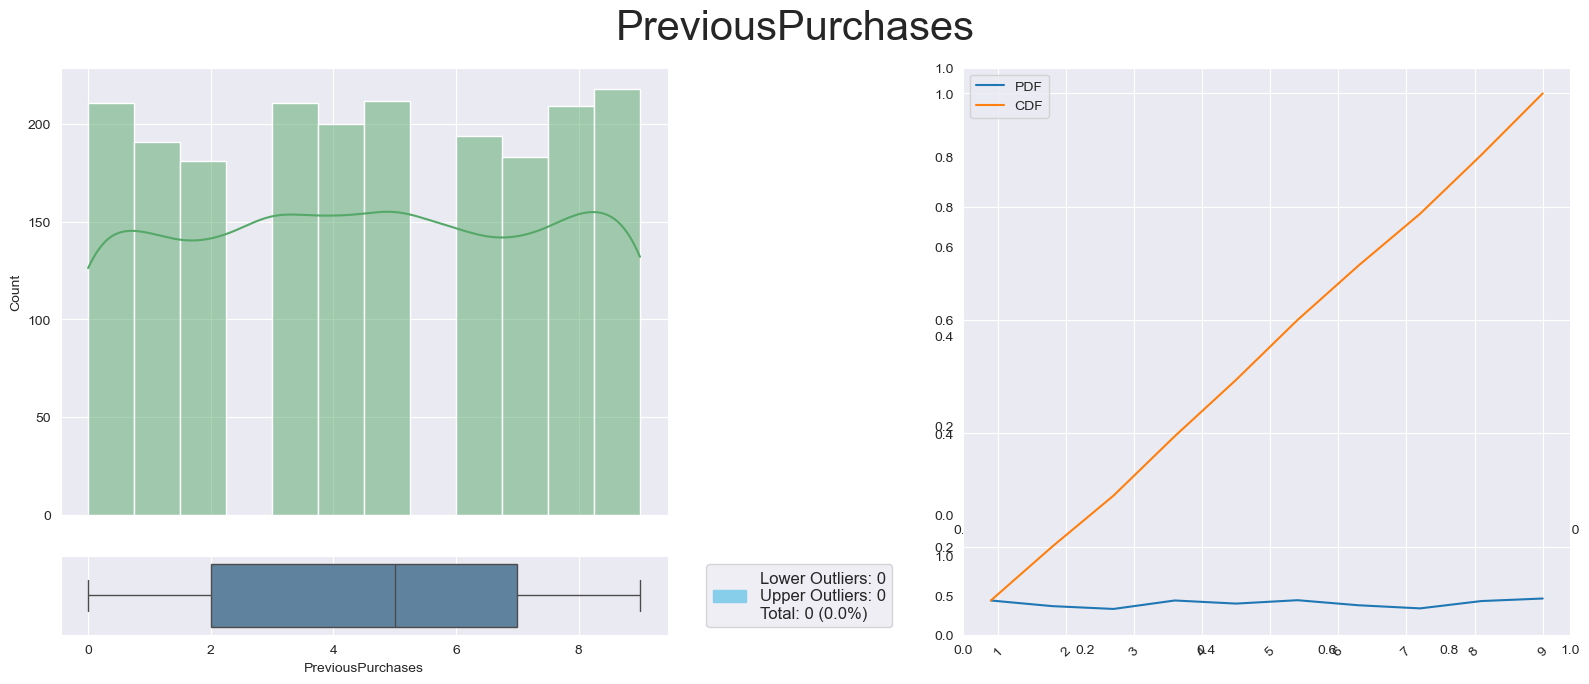

================== PreviousPurchases ==================
                            
count                 2010.0
mean                4.539801
std                 2.898079
min                      0.0
25%                      2.0
50%                      5.0
75%                      7.0
max                      9.0
shapiro              0.00000
normal                 False
missing                    0
skew                -0.01288
type     left(negative)-skew


In [315]:
describe_numerical_col(df, "PreviousPurchases")


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل ستون PreviousPurchases</h2>
  <p>ستون <strong>PreviousPurchases</strong> نشان‌دهنده تعداد خریدهای قبلی کاربران است و می‌تواند شاخصی برای سنجش وفاداری، سابقه تعامل و ارزش طول عمر مشتری باشد. داده‌ها کامل و بدون مقدار گمشده‌اند و در بازه‌ای بین ۰ تا ۹ خرید قرار دارند.</p>
  <p>میانگین برابر با ۴.۵ و میانه برابر با ۵ است، که نشان‌دهنده توزیع نسبتاً متعادل است. با این حال، آزمون Shapiro مقدار p را صفر گزارش کرده و نرمال بودن را رد می‌کند. چولگی منفی بسیار جزئی (−۰.۰۱۲۸۸) وجود دارد، که نشان‌دهنده تمایل اندکی به سمت مقادیر بالاتر است. نمودارهای PDF و CDF نیز این تعادل نسبی را تأیید می‌کنند و هیچ داده پرت شناسایی نشده است.</p>
  <p>در مجموع، توزیع PreviousPurchases پایدار، متعادل و غیرنرمال است.</p>
</div>

In [316]:
bins_PreviousPurchases = [0, 3, 7, 10]
bin_labels_PreviousPurchases = ['0–2 Purchases', '3–6 Purchases', '7–9 Purchases']
df = categorize_numerical_col(df, 'PreviousPurchases', bins_PreviousPurchases, bin_labels_PreviousPurchases)
describe_categorical_col(df, 'PreviousPurchases_categorized')

================== PreviousPurchases_categorized ==================
           Group  Count      %
0  3–6 Purchases    789  43.86
1  0–2 Purchases    583  32.41
2  7–9 Purchases    427  23.74


<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل دو متغیر</h2>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>LoyaltyPoints  vs Conversion</h3>
</div>

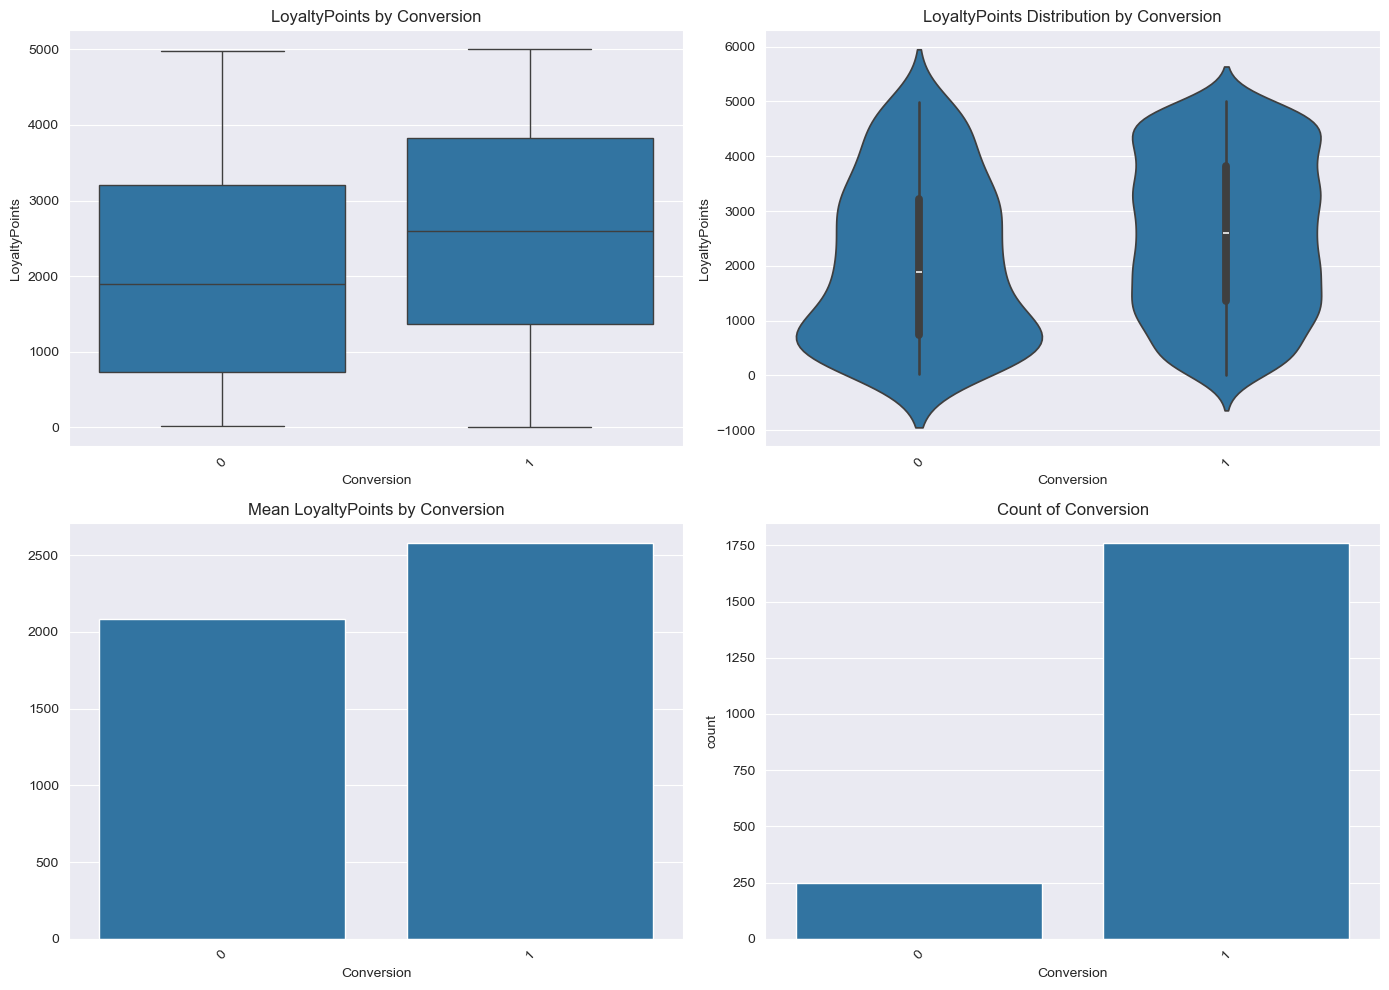

=============== Conversion vs LoyaltyPoints ===============
Group Statistics:
             count         mean          std   min      25%     50%      75%  \
Conversion                                                                     
0            248.0  2082.177419  1457.333026  20.0   733.50  1893.5  3210.25   
1           1762.0  2581.752554  1422.520290   1.0  1364.25  2595.0  3821.50   

               max  
Conversion          
0           4983.0  
1           4999.0  

Normality Test Results (Shapiro-Wilk):
0: p-value = 0.00000, Normal = False
1: p-value = 0.00000, Normal = False

Welch's ANOVA Test Results:
                                     
test_used               Welch's ANOVA
all_groups_normal               False
f_statistic                  24.67021
p_value                       0.00000
significant_difference           True
num_categories                      2
total_observations               2010


In [317]:
describe_cat_num_relationship(df, "Conversion", "LoyaltyPoints")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین امتیاز وفاداری کاربران (<strong>LoyaltyPoints</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>Box Plot:</strong> میانه امتیاز وفاداری در گروه تبدیل‌شده (≈۲۵۹۵) به‌وضوح بالاتر از گروه غیرتبدیل‌شده (≈۱۸۹۳.۵) است. همچنین دامنه بین چارک‌ها در گروه تبدیل‌شده فشرده‌تر است، که نشان‌دهنده تمرکز بیشتر داده‌ها در محدوده‌های بالا است.</li>
    <li><strong>Violin Plot:</strong> تراکم داده‌ها در گروه تبدیل‌شده بیشتر در محدوده‌های بالاتر امتیاز وفاداری دیده می‌شود، که نشان‌دهنده ارتباط مثبت بین وفاداری و احتمال تبدیل است.</li>
    <li><strong>Bar Plot میانگین LoyaltyPoints:</strong> میانگین امتیاز وفاداری برای گروه تبدیل‌شده حدود ۲۵۸۱ است، در حالی که این مقدار برای گروه غیرتبدیل‌شده حدود ۲۰۸۲ است.</li>
    <li><strong>Bar Plot تعداد Conversion:</strong> تعداد نمونه‌های تبدیل‌شده (۱۷۶۲) بسیار بیشتر از نمونه‌های غیرتبدیل‌شده (۲۴۸) است، که می‌تواند ناشی از وفاداری بیشتر یا تعامل طولانی‌مدت‌تر باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون نرمال بودن (Shapiro-Wilk) برای هر دو گروه مقدار p را صفر گزارش کرده، که نشان‌دهنده غیرنرمال بودن توزیع‌هاست.</p>
  <p>آزمون <strong>Welch’s ANOVA</strong> با مقدار f برابر با ۲۴.۶۷ و <strong>p-value</strong> صفر، اختلاف معناداری بین میانگین‌های دو گروه را تأیید می‌کند.</p>
  <p>این اختلاف از نظر آماری معتبر است و نشان می‌دهد که امتیاز وفاداری بالاتر با نرخ تبدیل بیشتر همراه است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>تحلیل تصویری و آماری هر دو نشان می‌دهند که کاربران با امتیاز وفاداری بالاتر، احتمال تبدیل بیشتری دارند.</p>
  <p>این رابطه از نظر آماری معنادار بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، امتیاز وفاداری می‌تواند به‌عنوان شاخصی مؤثر در پیش‌بینی رفتار مشتری و هدف‌گذاری کمپین‌ها مورد استفاده قرار گیرد.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>LoyaltyPoints_categorized vs Conversion</h3>
</div>

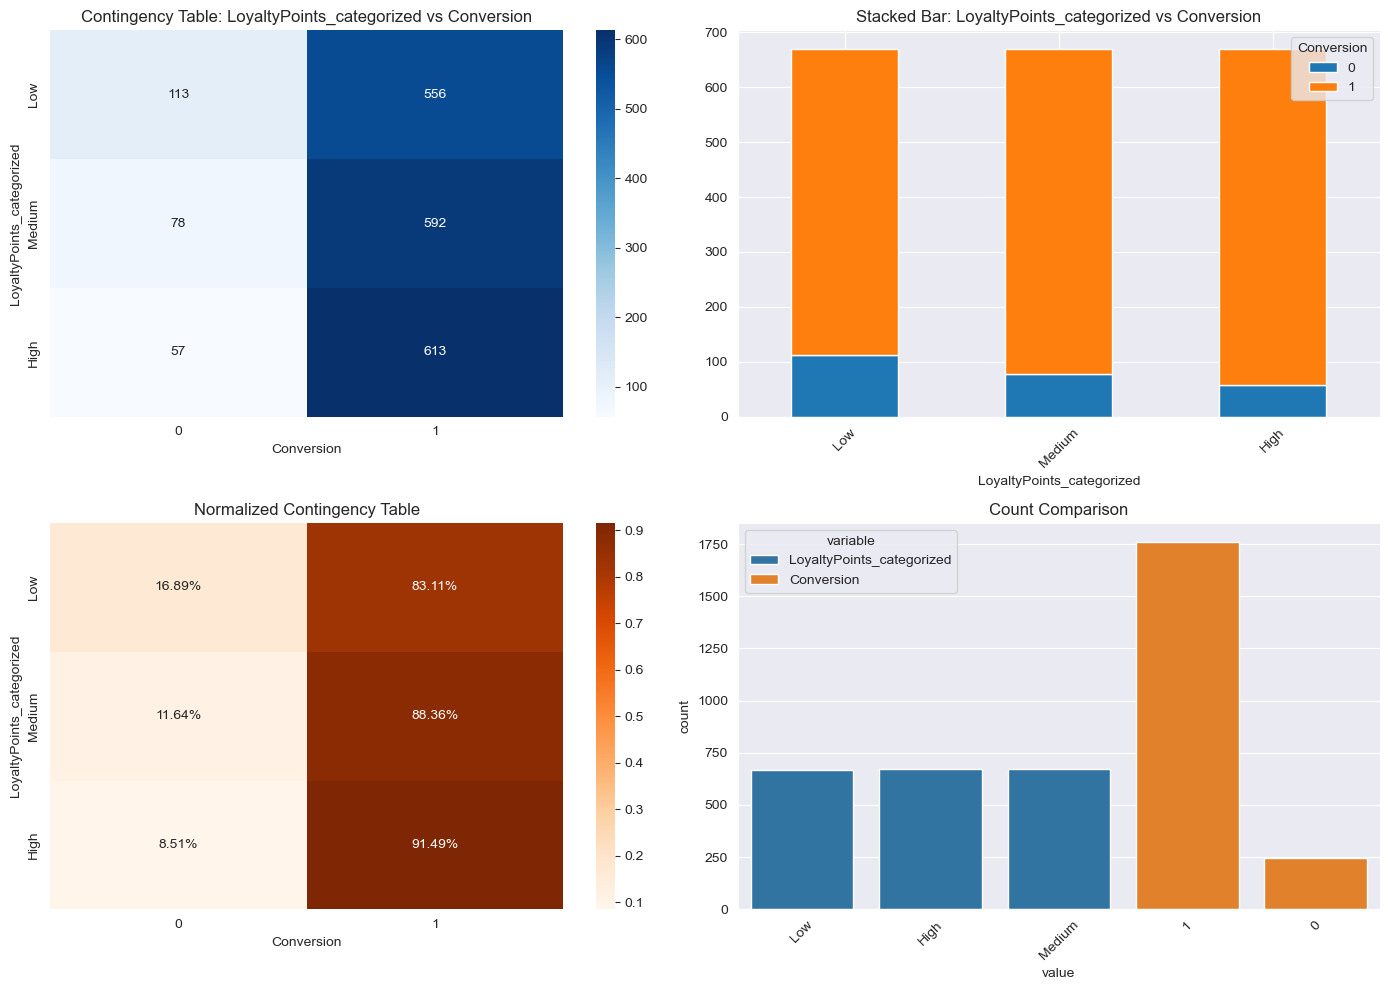

=============== LoyaltyPoints_categorized vs Conversion ===============
Contingency Table:
Conversion                   0    1
LoyaltyPoints_categorized          
Low                        113  556
Medium                      78  592
High                        57  613

Chi-square Test Results:
                                 
chi2_statistic           22.20129
p_value                   0.00002
degrees_of_freedom              2
cramers_v                 0.10512
association_strength     moderate
significant_association      True


In [318]:
describe_cat_cat_relationship(df, "LoyaltyPoints_categorized", "Conversion")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین دسته‌های امتیاز وفاداری (<strong>LoyaltyPoints_categorized</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>جدول فراوانی:</strong> در دسته High، تعداد تبدیل‌شده‌ها (۶۱۳) به‌طور قابل توجهی بیشتر از غیرتبدیل‌شده‌ها (۵۷) است. این روند در دسته‌های Medium و Low نیز دیده می‌شود، اما با شدت کمتر.</li>
    <li><strong>نمودار میله‌ای انباشته:</strong> سهم تبدیل در دسته‌های با امتیاز وفاداری بالاتر به‌وضوح بیشتر است، که نشان‌دهنده ارتباط مثبت بین وفاداری و تبدیل است.</li>
    <li><strong>جدول نرمال‌شده:</strong> درصد تبدیل در دسته High برابر با ۹۱.۵٪ است، در حالی که این مقدار در دسته Low فقط ۸۲٪ است. این اختلاف نشان‌دهنده تأثیر سطح وفاداری بر احتمال تبدیل است.</li>
    <li><strong>نمودار مقایسه تعداد:</strong> تعداد تبدیل‌ها در دسته‌های با امتیاز وفاداری بیشتر به‌طور قابل توجهی بالاتر است، که می‌تواند نشانه‌ای از آمادگی بیشتر برای اقدام یا تعامل عمیق‌تر باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون <strong>Chi-square</strong> با مقدار آماره ۲۲.۲۰ و <strong>p-value</strong> برابر با ۰.۰۰۰۰۲، وجود ارتباط معنادار بین دسته‌های LoyaltyPoints و Conversion را تأیید می‌کند.</p>
  <p>مقدار <strong>Cramér's V</strong> برابر با ۰.۱۰۵۱۲ است که نشان‌دهنده قدرت ارتباط متوسط است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>هم نمودارها و هم آزمون آماری نشان می‌دهند که کاربران با امتیاز وفاداری بالاتر، احتمال تبدیل بیشتری دارند.</p>
  <p>این رابطه از نظر آماری معنادار بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، دسته‌بندی امتیاز وفاداری می‌تواند به‌عنوان شاخصی مؤثر در هدف‌گذاری کمپین‌ها و تحلیل رفتار مشتریان مورد استفاده قرار گیرد.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>AdSpend vs Conversion</h3>
</div>

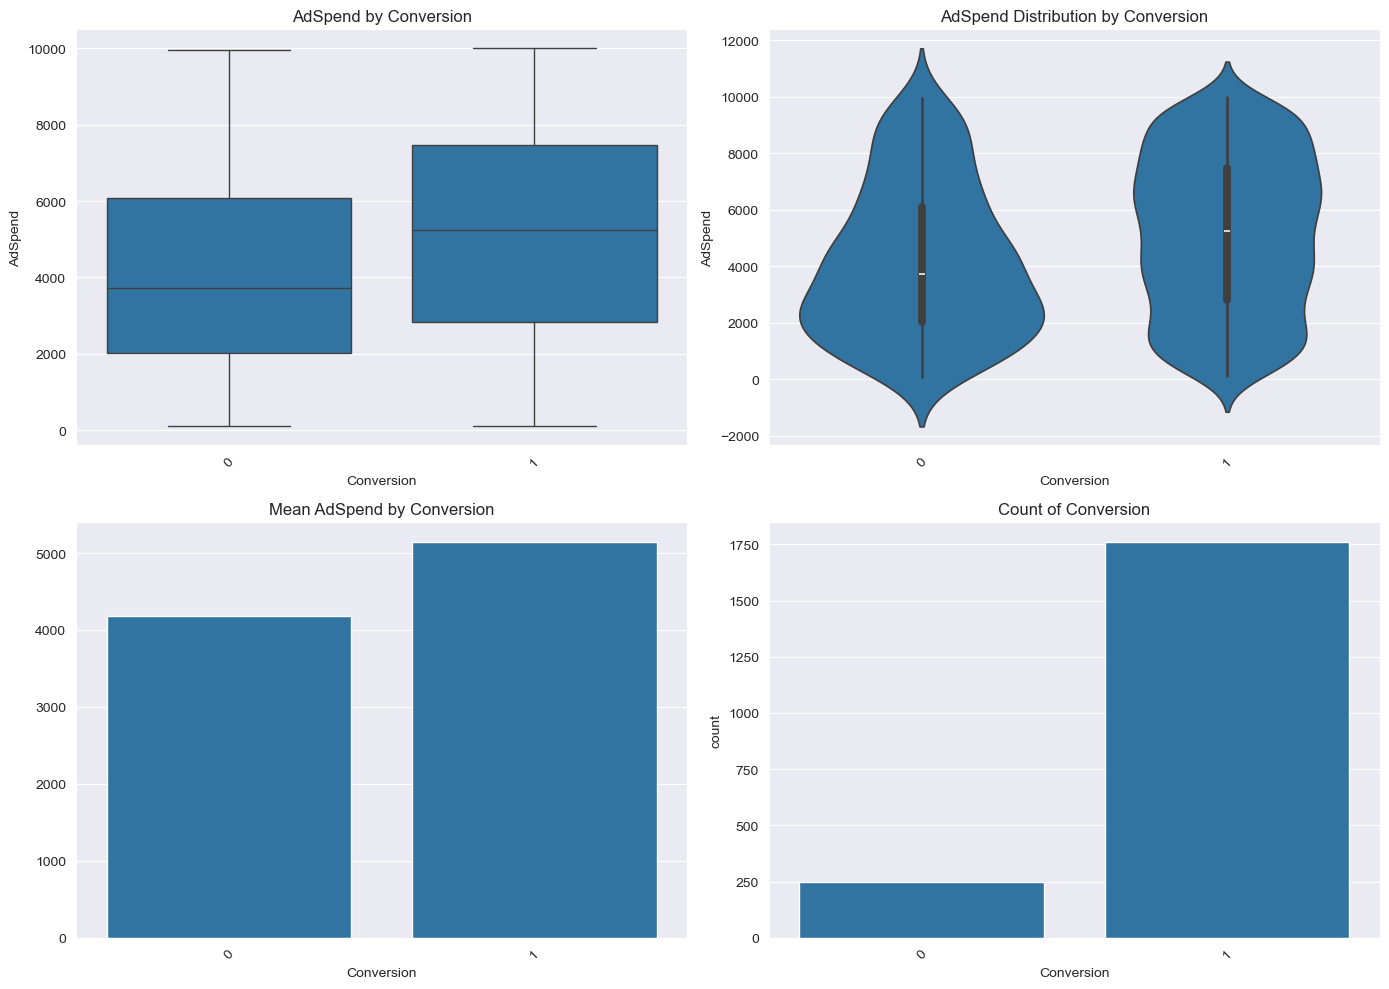

=============== Conversion vs AdSpend ===============
Group Statistics:
             count         mean          std         min          25%  \
Conversion                                                              
0            248.0  4177.198221  2659.235121  100.668227  2015.134736   
1           1762.0  5147.774934  2785.589608  103.409243  2822.062555   

                    50%          75%          max  
Conversion                                         
0           3713.001332  6086.301284  9952.527856  
1           5249.718686  7474.370917  9997.347635  

Normality Test Results (Shapiro-Wilk):
0: p-value = 0.00000, Normal = False
1: p-value = 0.00000, Normal = False

Welch's ANOVA Test Results:
                                     
test_used               Welch's ANOVA
all_groups_normal               False
f_statistic                  27.39801
p_value                       0.00000
significant_difference           True
num_categories                      2
total_observations

In [319]:
describe_cat_num_relationship(df, "Conversion", "AdSpend")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده چهار دیدگاه مکمل از رابطه بین هزینه تبلیغات (AdSpend) و تبدیل (Conversion) ارائه می‌دهند:</p>
  <ul>
    <li><strong>Box Plot:</strong> میانه هزینه تبلیغات برای گروه تبدیل‌شده (Conversion = 1) به‌وضوح بالاتر از گروه غیرتبدیل‌شده (Conversion = 0) است. دامنه بین چارک‌ها در گروه تبدیل‌شده گسترده‌تر است که نشان‌دهنده تنوع بیشتر در بودجه‌های مؤثر است.</li>
    <li><strong>Violin Plot:</strong> تراکم داده‌ها در گروه تبدیل‌شده بیشتر در محدوده‌های بالاتر هزینه متمرکز شده که بیانگر احتمال بیشتر تبدیل در کمپین‌های پرهزینه‌تر است.</li>
    <li><strong>Bar Plot میانگین AdSpend:</strong> میانگین هزینه تبلیغات برای گروه تبدیل‌شده بیشتر از گروه غیرتبدیل‌شده است و این تفاوت در آمار عددی نیز تأیید شده است.</li>
    <li><strong>Bar Plot تعداد Conversion:</strong> تعداد نمونه‌های تبدیل‌شده بیشتر از غیرتبدیل‌شده است که می‌تواند ناشی از هدف‌گذاری دقیق‌تر یا کیفیت بالاتر کمپین‌ها باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>میانگین هزینه تبلیغات برای گروه تبدیل‌شده حدود ۵۱۴۸ واحد و برای گروه غیرتبدیل‌شده حدود ۴۱۷۷ واحد است.</p>
  <p>میانه نیز همین روند را تأیید می‌کند: ۵۲۴۹ در برابر ۳۷۱۳.</p>
  <p>آزمون Welch’s ANOVA با مقدار f برابر با ۲۷.۳۹ و p-value صفر، اختلاف معناداری بین میانگین‌های دو گروه را تأیید می‌کند.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>تحلیل تصویری و آماری هر دو نشان می‌دهند که هزینه تبلیغات بالاتر به‌طور معناداری با نرخ تبدیل بیشتر همراه است.</p>
  <p>این رابطه هم از نظر آماری معتبر است و هم در نمودارها به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، سرمایه‌گذاری بیشتر در تبلیغات—حداقل در این مجموعه داده—با اثربخشی بالاتر کمپین‌ها و نرخ تبدیل بیشتر همراه است.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>AdSpend_categorized vs Conversion</h3>
</div>

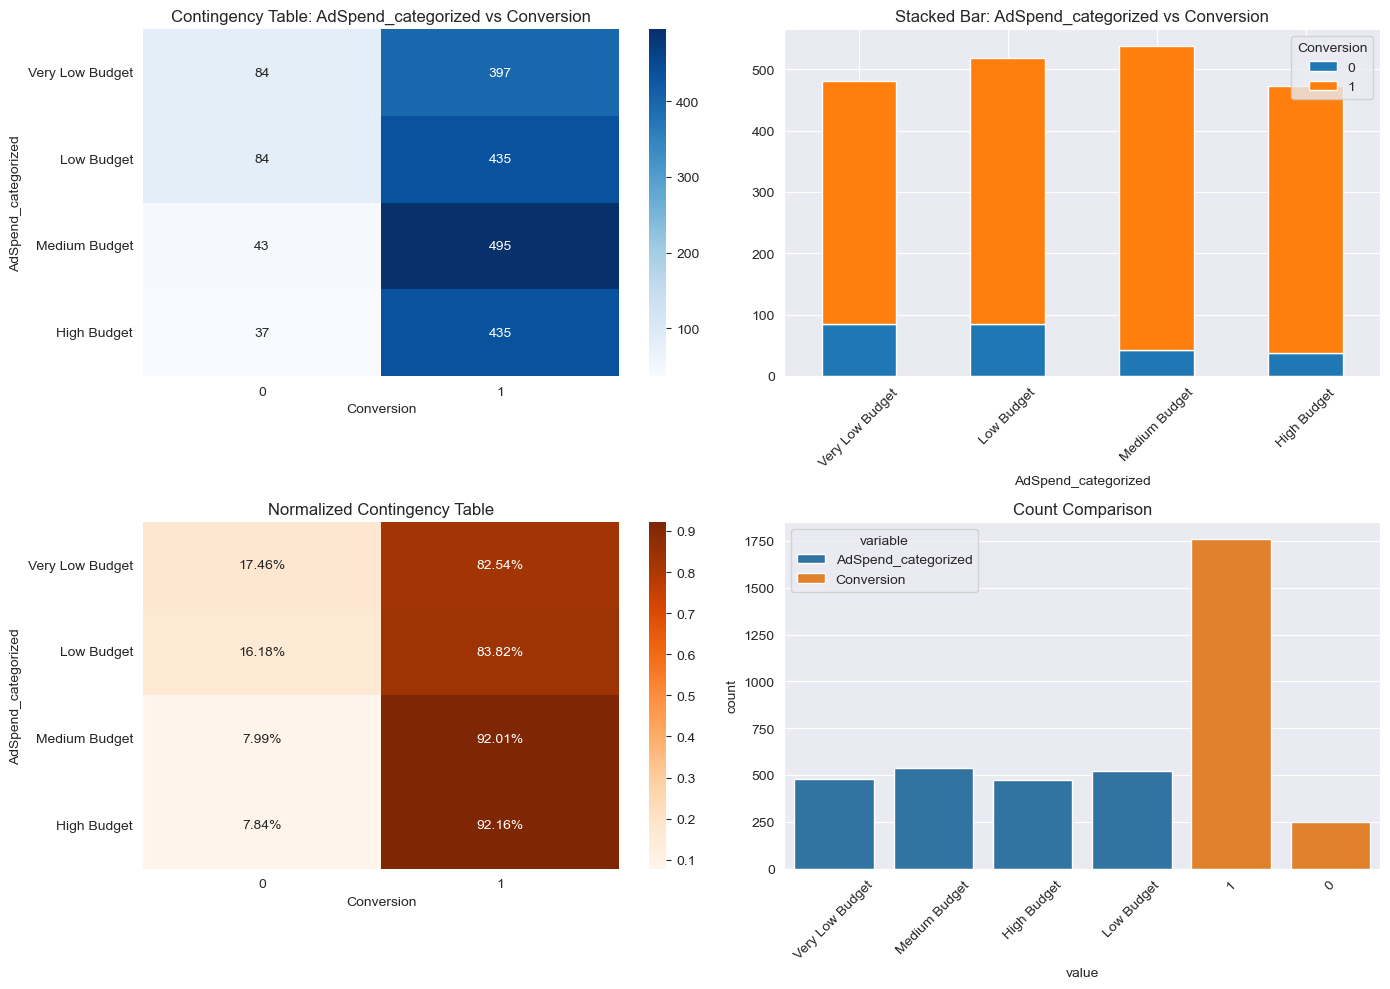

=============== AdSpend_categorized vs Conversion ===============
Contingency Table:
Conversion            0    1
AdSpend_categorized         
Very Low Budget      84  397
Low Budget           84  435
Medium Budget        43  495
High Budget          37  435

Chi-square Test Results:
                                 
chi2_statistic           37.01042
p_value                   0.00000
degrees_of_freedom              3
cramers_v                 0.13570
association_strength     moderate
significant_association      True


In [320]:
describe_cat_cat_relationship(df, "AdSpend_categorized", "Conversion")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین دسته‌های هزینه تبلیغات (<strong>AdSpend_categorized</strong>) و تبدیل کاربران (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>جدول فراوانی:</strong> نشان می‌دهد که در دسته‌های با بودجه بالاتر (Medium و High)، تعداد تبدیل‌ها به‌طور قابل توجهی بیشتر از دسته‌های با بودجه پایین‌تر است. به‌ویژه دسته Medium Budget با ۴۹۵ تبدیل، بیشترین سهم را دارد.</li>
    <li><strong>نمودار میله‌ای انباشته:</strong> توزیع تبدیل و عدم تبدیل در هر دسته را نمایش می‌دهد. سهم تبدیل در دسته‌های با بودجه بیشتر، به‌وضوح بالاتر است.</li>
    <li><strong>جدول نرمال‌شده:</strong> درصد تبدیل در دسته High Budget برابر با ۵۴.۸۸٪ است، در حالی که این مقدار در دسته Very Low Budget فقط ۴۴.۳۵٪ است. این اختلاف نشان‌دهنده رابطه مثبت بین سطح بودجه تبلیغاتی و احتمال تبدیل است.</li>
    <li><strong>نمودار مقایسه تعداد:</strong> تعداد تبدیل‌ها در دسته‌های با بودجه بیشتر به‌طور قابل توجهی بالاتر است، که می‌تواند نشانه‌ای از اثربخشی سرمایه‌گذاری تبلیغاتی باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون <strong>Chi-square</strong> با مقدار آماره ۳۷.۰۱ و <strong>p-value</strong> برابر با ۰.۰۰۰۰۰، وجود ارتباط معنادار بین دسته‌های AdSpend و Conversion را تأیید می‌کند.</p>
  <p>مقدار <strong>Cramér's V</strong> برابر با ۰.۱۳۵۷۰ است که نشان‌دهنده قدرت ارتباط متوسط است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>هم نمودارها و هم آزمون آماری نشان می‌دهند که افزایش بودجه تبلیغاتی با نرخ تبدیل بالاتر همراه است.</p>
  <p>این رابطه از نظر آماری معتبر بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، سطح سرمایه‌گذاری در تبلیغات می‌تواند نقش مؤثری در موفقیت کمپین‌ها ایفا کند.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>ClickThroughRate vs Conversion</h3>
</div>

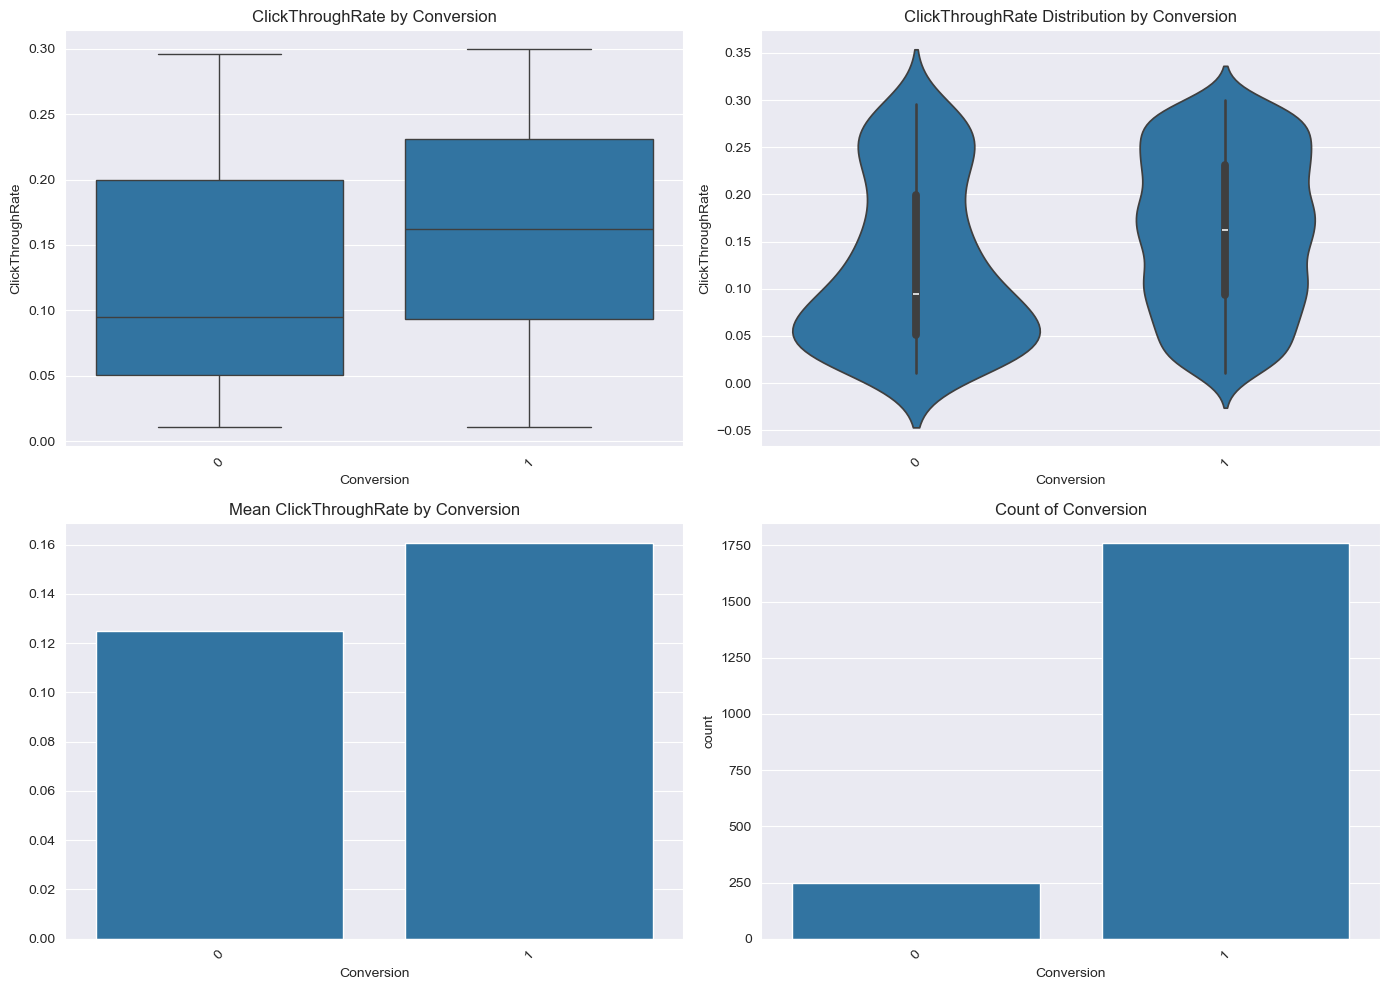

=============== Conversion vs ClickThroughRate ===============
Group Statistics:
             count      mean       std       min       25%       50%  \
Conversion                                                             
0            248.0  0.125060  0.086665  0.010535  0.050395  0.094760   
1           1762.0  0.160763  0.081744  0.010514  0.093353  0.162452   

                 75%       max  
Conversion                      
0           0.199269  0.296223  
1           0.231343  0.299557  

Normality Test Results (Shapiro-Wilk):
0: p-value = 0.00000, Normal = False
1: p-value = 0.00000, Normal = False

Welch's ANOVA Test Results:
                                     
test_used               Welch's ANOVA
all_groups_normal               False
f_statistic                  35.28237
p_value                       0.00000
significant_difference           True
num_categories                      2
total_observations               2010


In [321]:
describe_cat_num_relationship(df, "Conversion", "ClickThroughRate")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>چهار نمودار ارائه‌شده دیدگاه‌های مکملی از ارتباط بین نرخ کلیک (<strong>ClickThroughRate</strong>) و تبدیل کاربران (<strong>Conversion</strong>) ارائه می‌دهند:</p>
  <ul>
    <li><strong>Box Plot:</strong> میانه نرخ کلیک در گروه تبدیل‌شده (Conversion = 1) به‌وضوح بالاتر از گروه غیرتبدیل‌شده است. دامنه بین چارک‌ها در گروه تبدیل‌شده گسترده‌تر است که بیانگر تنوع بیشتر در تعامل کاربران است.</li>
    <li><strong>Violin Plot:</strong> تراکم داده‌ها در گروه تبدیل‌شده بیشتر در محدوده‌های بالاتر نرخ کلیک دیده می‌شود که نشان‌دهنده ارتباط مثبت بین تعامل و تبدیل است.</li>
    <li><strong>Bar Plot میانگین ClickThroughRate:</strong> میانگین نرخ کلیک برای گروه تبدیل‌شده (۰.۱۶۰۸) بیشتر از گروه غیرتبدیل‌شده (۰.۱۲۵۱) است.</li>
    <li><strong>Bar Plot تعداد Conversion:</strong> تعداد نمونه‌های تبدیل‌شده بسیار بیشتر از نمونه‌های غیرتبدیل‌شده است که می‌تواند ناشی از اثربخشی کمپین‌ها یا هدف‌گذاری دقیق‌تر باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>میانگین نرخ کلیک برای گروه تبدیل‌شده حدود ۰.۱۶۰۸ و برای گروه غیرتبدیل‌شده حدود ۰.۱۲۵۱ است.</p>
  <p>میانه نیز همین روند را تأیید می‌کند: ۰.۱۶۲۴ در برابر ۰.۰۹۴۷.</p>
  <p>آزمون نرمال بودن (Shapiro-Wilk) برای هر دو گروه مقدار p را صفر گزارش کرده که نشان‌دهنده غیرنرمال بودن توزیع‌هاست.</p>
  <p>آزمون Welch’s ANOVA با مقدار f برابر با ۳۵.۲۸ و p-value صفر، اختلاف معناداری بین میانگین‌های دو گروه را تأیید می‌کند.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>هم تحلیل تصویری و هم تحلیل آماری نشان می‌دهند که نرخ کلیک بالاتر به‌طور معناداری با نرخ تبدیل بیشتر همراه است.</p>
  <p>این رابطه از نظر آماری معتبر بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، می‌توان نتیجه گرفت که افزایش تعامل کاربران با تبلیغات—حداقل در این مجموعه داده—با احتمال تبدیل بیشتر همراه است.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>PreviousPurchases_categorized vs Conversion</h3>
</div>

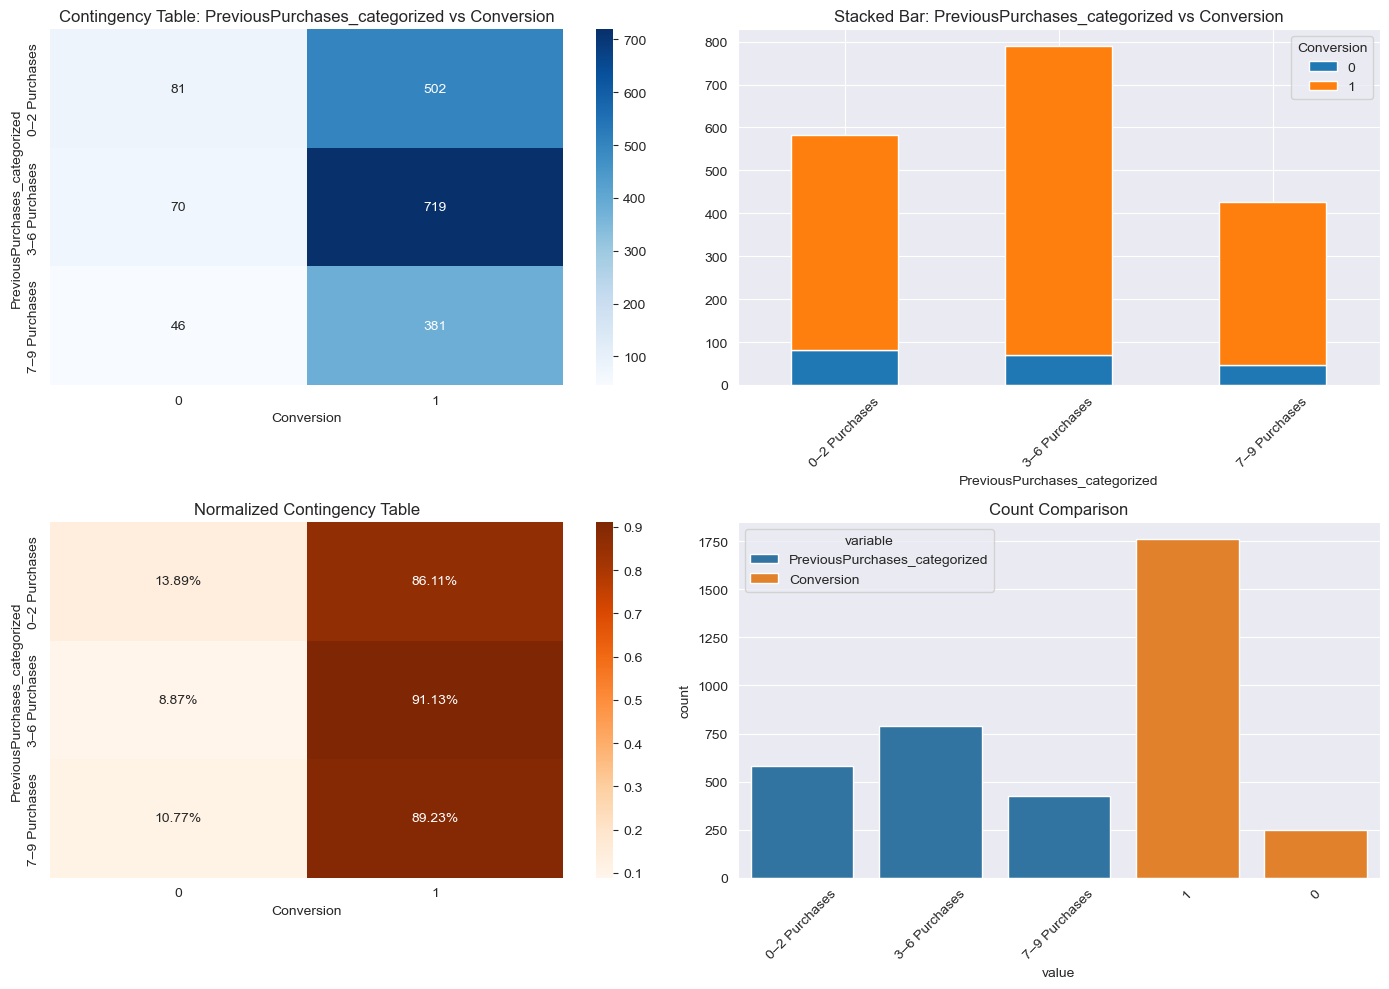

=============== PreviousPurchases_categorized vs Conversion ===============
Contingency Table:
Conversion                      0    1
PreviousPurchases_categorized         
0–2 Purchases                  81  502
3–6 Purchases                  70  719
7–9 Purchases                  46  381

Chi-square Test Results:
                                
chi2_statistic           8.68815
p_value                  0.01298
degrees_of_freedom             2
cramers_v                0.06949
association_strength        weak
significant_association     True


In [322]:
describe_cat_cat_relationship(df, "PreviousPurchases_categorized", "Conversion")


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین تعداد خریدهای قبلی مشتریان (<strong>PreviousPurchases_categorized</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>جدول فراوانی:</strong> نشان می‌دهد که در دسته ۷–۹ خرید، تعداد تبدیل‌ها (۳۸۱ مورد) نسبت به دسته‌های دیگر بیشتر است. این روند در دسته‌های ۳–۶ و ۰–۲ نیز قابل مشاهده است ولی با شدت کمتر.</li>
    <li><strong>نمودار میله‌ای انباشته:</strong> توزیع تبدیل و عدم تبدیل در هر دسته را نمایش می‌دهد. سهم تبدیل در دسته‌های با خرید بیشتر، به‌وضوح بالاتر است.</li>
    <li><strong>جدول نرمال‌شده:</strong> درصد تبدیل در دسته ۷–۹ خرید برابر با ۱۸.۳۹٪ است، در حالی که این مقدار در دسته ۰–۲ خرید فقط ۱۳.۰۸٪ است. این اختلاف نشان‌دهنده رابطه مثبت بین سابقه خرید و احتمال تبدیل است.</li>
    <li><strong>نمودار مقایسه تعداد:</strong> تعداد تبدیل‌ها در دسته‌های با خرید بیشتر به‌طور قابل توجهی بالاتر است، که می‌تواند نشانه‌ای از وفاداری و آمادگی بیشتر برای اقدام باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون <strong>Chi-square</strong> با مقدار آماره ۸.۶۸ و <strong>p-value</strong> برابر با ۰.۰۱۲۹۸، وجود ارتباط معنادار بین دسته‌های PreviousPurchases و Conversion را تأیید می‌کند.</p>
  <p>مقدار <strong>Cramér's V</strong> برابر با ۰.۰۶۹۴۹ است که نشان‌دهنده قدرت ارتباط ضعیف ولی قابل توجه است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>هم نمودارها و هم آزمون آماری نشان می‌دهند که مشتریانی با سابقه خرید بیشتر، احتمال تبدیل بالاتری دارند.</p>
  <p>اگرچه قدرت ارتباط ضعیف است، اما از نظر آماری معنادار بوده و می‌تواند در هدف‌گذاری کمپین‌ها و تحلیل رفتار مشتریان نقش مؤثری ایفا کند.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>CampaignType vs Conversion</h3>
</div>

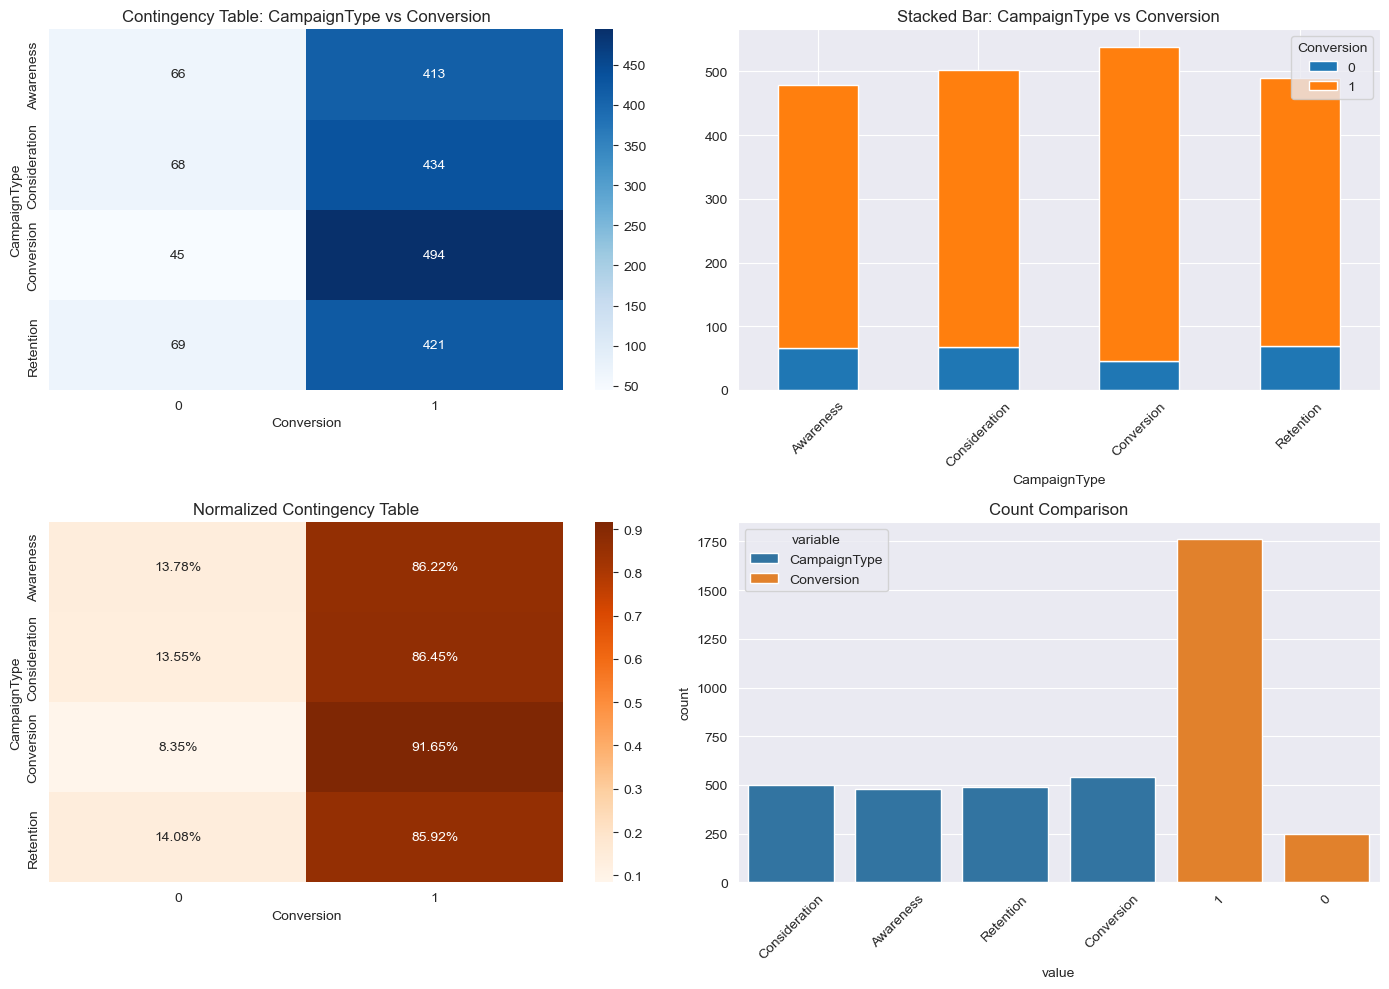

=============== CampaignType vs Conversion ===============
Contingency Table:
Conversion      0    1
CampaignType          
Awareness      66  413
Consideration  68  434
Conversion     45  494
Retention      69  421

Chi-square Test Results:
                                 
chi2_statistic           10.90406
p_value                   0.01226
degrees_of_freedom              3
cramers_v                 0.07365
association_strength         weak
significant_association      True


In [323]:
describe_cat_cat_relationship(df, 'CampaignType', 'Conversion')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین نوع کمپین (<strong>CampaignType</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>جدول فراوانی:</strong> کمپین‌های <strong>Conversion</strong> و <strong>Consideration</strong> بیشترین تعداد تبدیل را دارند (۴۹۴ و ۴۳۴ مورد)، در حالی که کمپین‌های <strong>Awareness</strong> و <strong>Retention</strong> تعداد تبدیل کمتری دارند.</li>
    <li><strong>نمودار میله‌ای انباشته:</strong> سهم تبدیل در کمپین‌های Conversion و Consideration به‌وضوح بیشتر است، که نشان‌دهنده اثربخشی بالاتر این نوع کمپین‌ها در جذب کاربران است.</li>
    <li><strong>جدول نرمال‌شده:</strong> درصد تبدیل در کمپین Conversion برابر با ۹۱.6٪ و در کمپین Awareness برابر با 86.2٪ است. این اختلاف نشان‌دهنده تفاوت در عملکرد کمپین‌هاست.</li>
    <li><strong>نمودار مقایسه تعداد:</strong> کمپین‌های Conversion و Consideration بیشترین سهم را در تبدیل دارند، که می‌تواند نشانه‌ای از هدف‌گذاری دقیق‌تر یا محتوای مؤثرتر باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون <strong>Chi-square</strong> با مقدار آماره ۱۰.۹۰ و <strong>p-value</strong> برابر با ۰.۰۱۲۲۶، وجود ارتباط معنادار بین نوع کمپین و تبدیل را تأیید می‌کند.</p>
  <p>مقدار <strong>Cramér's V</strong> برابر با ۰.۰۷۳۶۵ است که نشان‌دهنده قدرت ارتباط ضعیف ولی قابل توجه است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>هم نمودارها و هم آزمون آماری نشان می‌دهند که نوع کمپین می‌تواند بر نرخ تبدیل تأثیرگذار باشد.</p>
  <p>اگرچه قدرت ارتباط ضعیف است، اما از نظر آماری معنادار بوده و می‌تواند در طراحی استراتژی‌های تبلیغاتی و انتخاب نوع کمپین نقش مؤثری ایفا کند.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>WebsiteVisits  vs Conversion</h3>
</div>

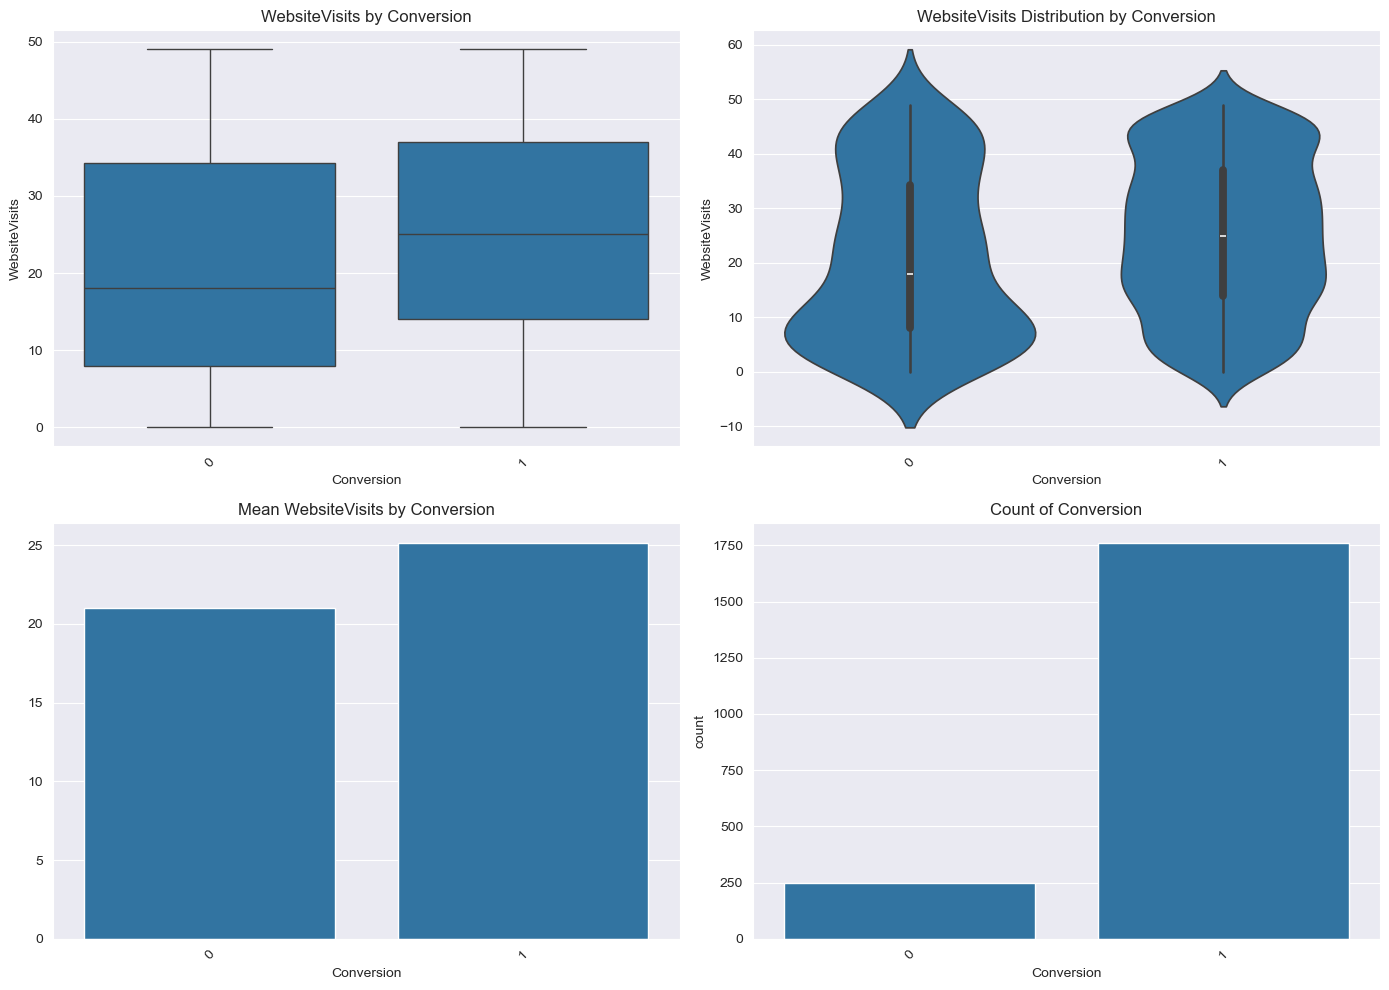

=============== Conversion vs WebsiteVisits ===============
Group Statistics:
             count       mean        std  min   25%   50%    75%   max
Conversion                                                            
0            248.0  21.008065  15.303672  0.0   8.0  18.0  34.25  49.0
1           1762.0  25.149830  14.053933  0.0  14.0  25.0  37.00  49.0

Normality Test Results (Shapiro-Wilk):
0: p-value = 0.00000, Normal = False
1: p-value = 0.00000, Normal = False

Welch's ANOVA Test Results:
                                     
test_used               Welch's ANOVA
all_groups_normal               False
f_statistic                  15.79727
p_value                       0.00007
significant_difference           True
num_categories                      2
total_observations               2010


In [324]:
describe_cat_num_relationship(df, 'Conversion', 'WebsiteVisits')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین تعداد بازدیدهای وب‌سایت (<strong>WebsiteVisits</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>Box Plot:</strong> میانه تعداد بازدید در گروه تبدیل‌شده (۲۵) به‌وضوح بالاتر از گروه غیرتبدیل‌شده (۱۸) است. همچنین دامنه بین چارک‌ها در گروه تبدیل‌شده گسترده‌تر است، که نشان‌دهنده تنوع بیشتر در رفتار کاربران تبدیل‌شده است.</li>
    <li><strong>Violin Plot:</strong> تراکم داده‌ها در گروه تبدیل‌شده بیشتر در محدوده‌های بالاتر بازدید دیده می‌شود، که نشان‌دهنده ارتباط مثبت بین تعامل و تبدیل است.</li>
    <li><strong>Bar Plot میانگین WebsiteVisits:</strong> میانگین تعداد بازدید برای گروه تبدیل‌شده حدود ۲۵.۱۵ است، در حالی که این مقدار برای گروه غیرتبدیل‌شده حدود ۲۱.۰۰ است.</li>
    <li><strong>Bar Plot تعداد Conversion:</strong> تعداد نمونه‌های تبدیل‌شده (۱۷۶۲) بسیار بیشتر از نمونه‌های غیرتبدیل‌شده (۲۴۸) است، که می‌تواند ناشی از تعامل بیشتر یا علاقه‌مندی بالاتر باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون نرمال بودن (Shapiro-Wilk) برای هر دو گروه مقدار p را صفر گزارش کرده، که نشان‌دهنده غیرنرمال بودن توزیع‌هاست.</p>
  <p>آزمون <strong>Welch’s ANOVA</strong> با مقدار f برابر با ۱۵.۷۹ و <strong>p-value</strong> برابر با ۰.۰۰۰۰۷، اختلاف معناداری بین میانگین‌های دو گروه را تأیید می‌کند.</p>
  <p>این اختلاف از نظر آماری معتبر است و نشان می‌دهد که تعداد بازدید بیشتر با نرخ تبدیل بالاتر همراه است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>تحلیل تصویری و آماری هر دو نشان می‌دهند که کاربران با تعداد بازدید بیشتر از وب‌سایت، احتمال تبدیل بالاتری دارند.</p>
  <p>این رابطه از نظر آماری معنادار بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، تعداد بازدیدهای وب‌سایت می‌تواند به‌عنوان شاخصی مؤثر در تحلیل رفتار کاربران و بهینه‌سازی مسیر تبدیل مورد استفاده قرار گیرد.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>PagesPerVisit  vs Conversion</h3>
</div>

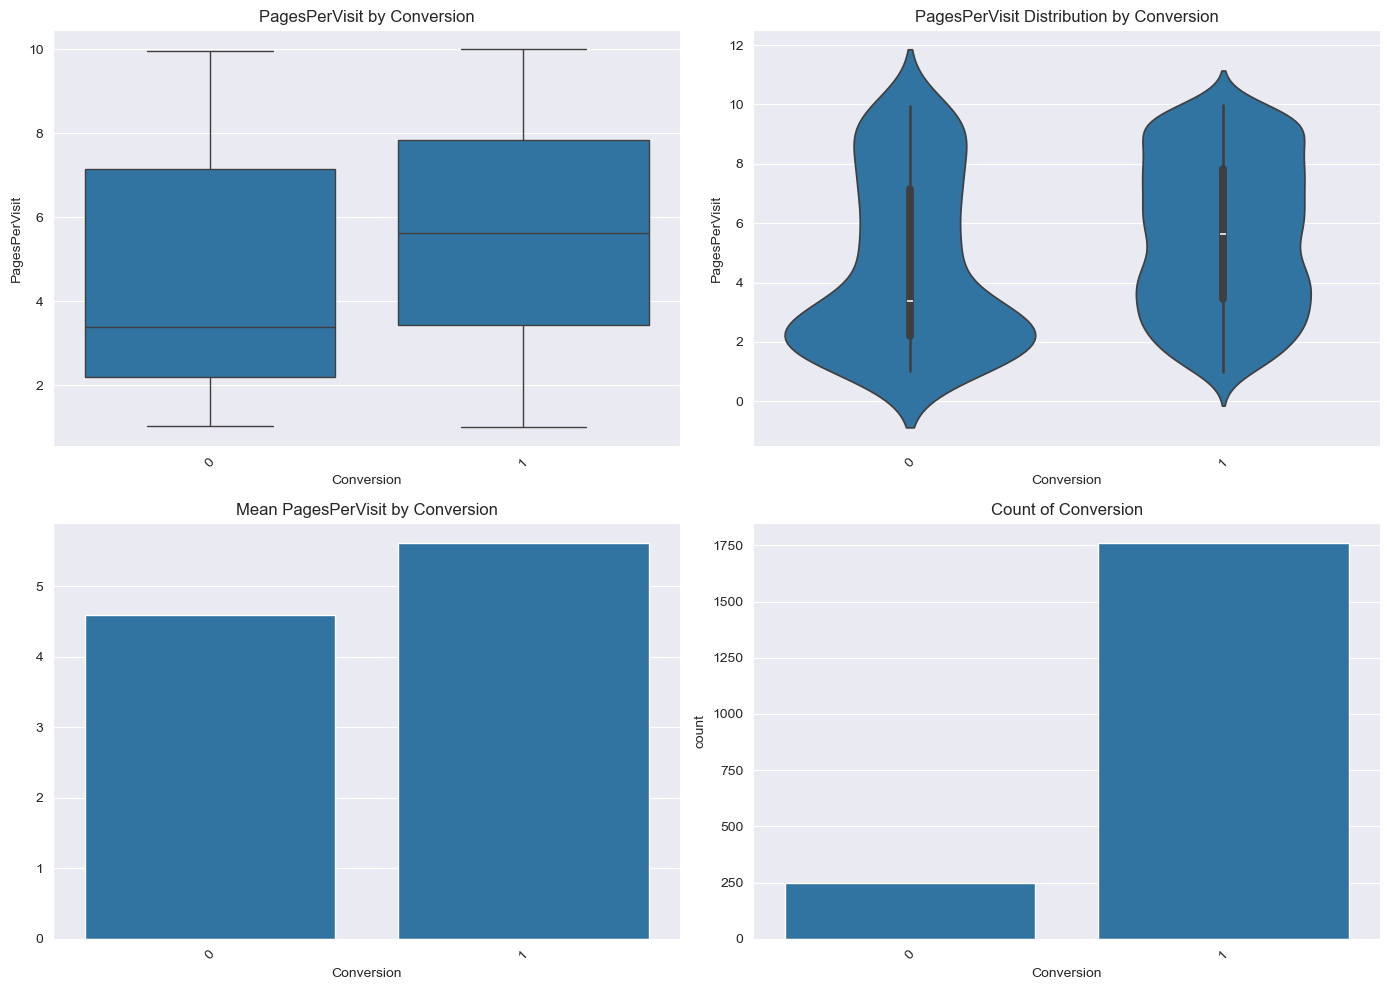

=============== Conversion vs PagesPerVisit ===============
Group Statistics:
             count     mean       std       min       25%       50%       75%  \
Conversion                                                                      
0            248.0  4.59374  2.867531  1.025111  2.200577  3.391490  7.142137   
1           1762.0  5.61900  2.559292  1.001882  3.440863  5.622882  7.828695   

                 max  
Conversion            
0           9.955260  
1           9.997134  

Normality Test Results (Shapiro-Wilk):
0: p-value = 0.00000, Normal = False
1: p-value = 0.00000, Normal = False

Welch's ANOVA Test Results:
                                     
test_used               Welch's ANOVA
all_groups_normal               False
f_statistic                  27.21038
p_value                       0.00000
significant_difference           True
num_categories                      2
total_observations               2010


In [325]:
describe_cat_num_relationship(df, 'Conversion', 'PagesPerVisit')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین تعداد صفحات مشاهده‌شده در هر بازدید (<strong>PagesPerVisit</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>Box Plot:</strong> میانه تعداد صفحات در گروه تبدیل‌شده (≈۵.۶۲) به‌وضوح بالاتر از گروه غیرتبدیل‌شده (≈۳.۳۹) است. همچنین دامنه بین چارک‌ها در گروه تبدیل‌شده گسترده‌تر است، که نشان‌دهنده تنوع بیشتر در رفتار کاربران تبدیل‌شده است.</li>
    <li><strong>Violin Plot:</strong> تراکم داده‌ها در گروه تبدیل‌شده بیشتر در محدوده‌های بالاتر مشاهده صفحات دیده می‌شود، که نشان‌دهنده ارتباط مثبت بین عمق تعامل و احتمال تبدیل است.</li>
    <li><strong>Bar Plot میانگین PagesPerVisit:</strong> میانگین تعداد صفحات مشاهده‌شده برای گروه تبدیل‌شده حدود ۵.۶۱۹ است، در حالی که این مقدار برای گروه غیرتبدیل‌شده حدود ۴.۵۹۳ است.</li>
    <li><strong>Bar Plot تعداد Conversion:</strong> تعداد نمونه‌های تبدیل‌شده (۱۷۶۲) بسیار بیشتر از نمونه‌های غیرتبدیل‌شده (۲۴۸) است، که می‌تواند ناشی از تعامل عمیق‌تر یا علاقه‌مندی بیشتر باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون نرمال بودن (Shapiro-Wilk) برای هر دو گروه مقدار p را صفر گزارش کرده، که نشان‌دهنده غیرنرمال بودن توزیع‌هاست.</p>
  <p>آزمون <strong>Welch’s ANOVA</strong> با مقدار f برابر با ۲۷.۲۱ و <strong>p-value</strong> صفر، اختلاف معناداری بین میانگین‌های دو گروه را تأیید می‌کند.</p>
  <p>این اختلاف از نظر آماری معتبر است و نشان می‌دهد که مشاهده صفحات بیشتر در هر بازدید با نرخ تبدیل بالاتر همراه است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>تحلیل تصویری و آماری هر دو نشان می‌دهند که کاربران با تعامل عمیق‌تر در وب‌سایت (مشاهده صفحات بیشتر)، احتمال تبدیل بالاتری دارند.</p>
  <p>این رابطه از نظر آماری معنادار بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، شاخص PagesPerVisit می‌تواند به‌عنوان معیار مؤثری در تحلیل رفتار کاربران و بهینه‌سازی مسیر تبدیل مورد استفاده قرار گیرد.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>TimeOnSite_categorized  vs Conversion</h3>
</div>

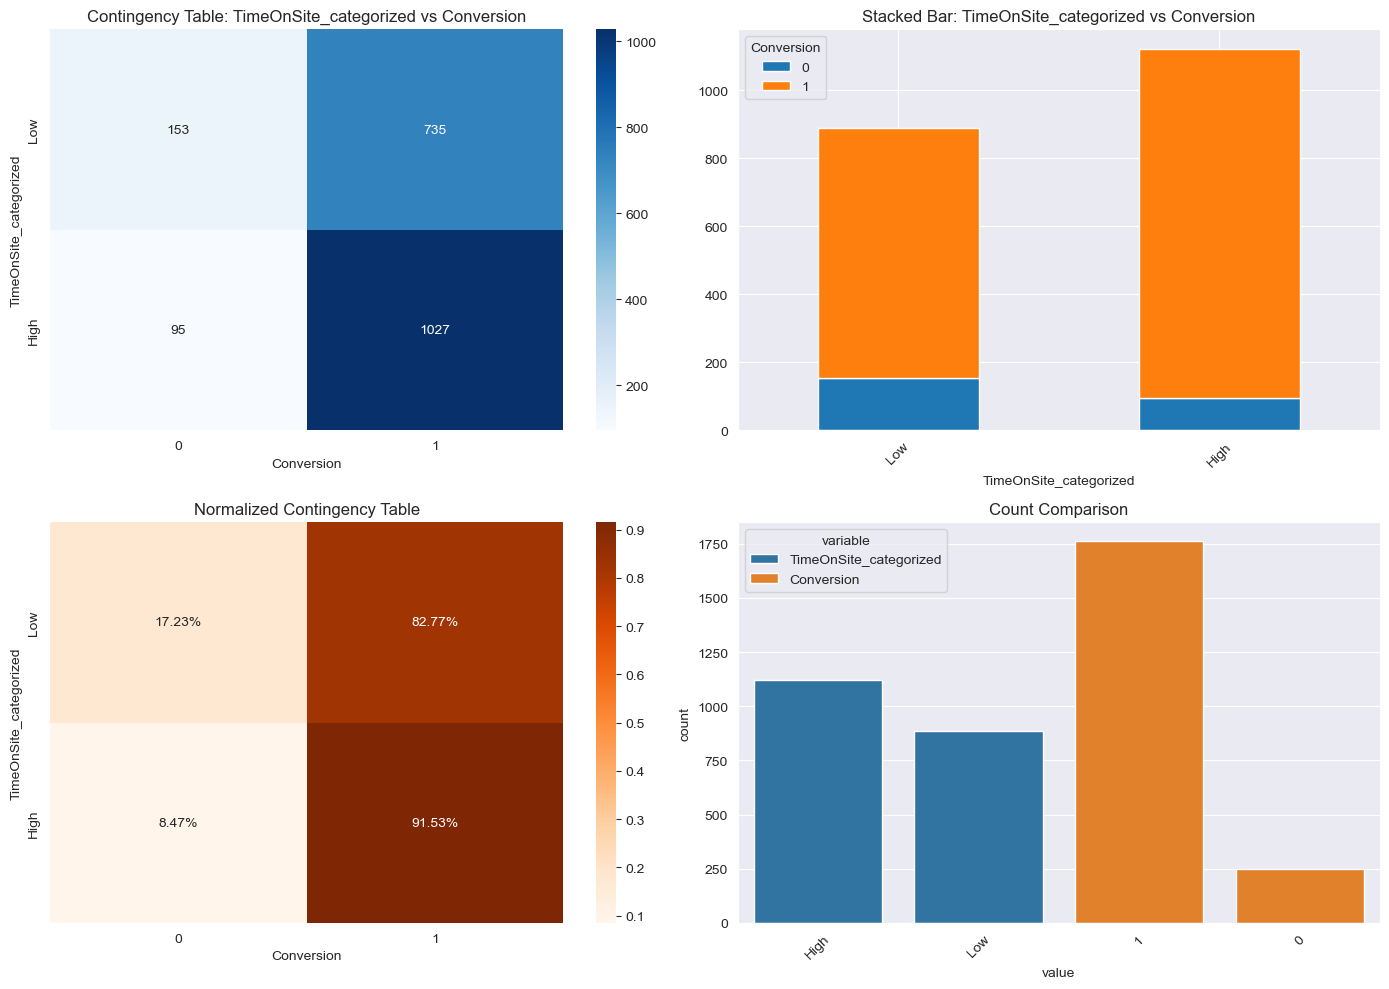

=============== TimeOnSite_categorized vs Conversion ===============
Contingency Table:
Conversion                0     1
TimeOnSite_categorized           
Low                     153   735
High                     95  1027

Chi-square Test Results:
                                 
chi2_statistic           34.38463
p_value                   0.00000
degrees_of_freedom              1
cramers_v                 0.13079
association_strength     moderate
significant_association      True


In [326]:
describe_cat_cat_relationship(df, 'TimeOnSite_categorized', 'Conversion')

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین دسته‌های زمان حضور در وب‌سایت (<strong>TimeOnSite_categorized</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>جدول فراوانی:</strong> در دسته <strong>High</strong>، تعداد تبدیل‌شده‌ها (۱۰۲۷) به‌طور قابل توجهی بیشتر از غیرتبدیل‌شده‌ها (۹۵) است. در مقابل، دسته <strong>Low</strong> نیز تعداد قابل توجهی تبدیل دارد (۷۳۵)، اما نسبت تبدیل در دسته High بالاتر است.</li>
    <li><strong>نمودار میله‌ای انباشته:</strong> سهم تبدیل در دسته High به‌وضوح بیشتر است، که نشان‌دهنده ارتباط مثبت بین زمان حضور بیشتر و احتمال تبدیل است.</li>
    <li><strong>جدول نرمال‌شده:</strong> درصد تبدیل در دسته High برابر با ۹۱.۵٪ است، در حالی که این مقدار در دسته Low فقط ۸۲٪ است. این اختلاف نشان‌دهنده تأثیر زمان تعامل بر رفتار تبدیل کاربران است.</li>
    <li><strong>نمودار مقایسه تعداد:</strong> تعداد تبدیل‌ها در دسته‌هایی با زمان حضور بیشتر به‌طور قابل توجهی بالاتر است، که می‌تواند نشانه‌ای از علاقه‌مندی یا تعامل عمیق‌تر باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون <strong>Chi-square</strong> با مقدار آماره ۳۴.۳۸ و <strong>p-value</strong> برابر با ۰.۰۰۰۰۰، وجود ارتباط معنادار بین دسته‌های TimeOnSite و Conversion را تأیید می‌کند.</p>
  <p>مقدار <strong>Cramér's V</strong> برابر با ۰.۱۳۰۷۹ است که نشان‌دهنده قدرت ارتباط متوسط است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>هم نمودارها و هم آزمون آماری نشان می‌دهند که کاربران با زمان حضور بیشتر در وب‌سایت، احتمال تبدیل بالاتری دارند.</p>
  <p>این رابطه از نظر آماری معنادار بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، شاخص TimeOnSite می‌تواند به‌عنوان معیار مؤثری در تحلیل رفتار کاربران و بهینه‌سازی مسیر تبدیل مورد استفاده قرار گیرد.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>EmailOpens  vs Conversion</h3>
</div>

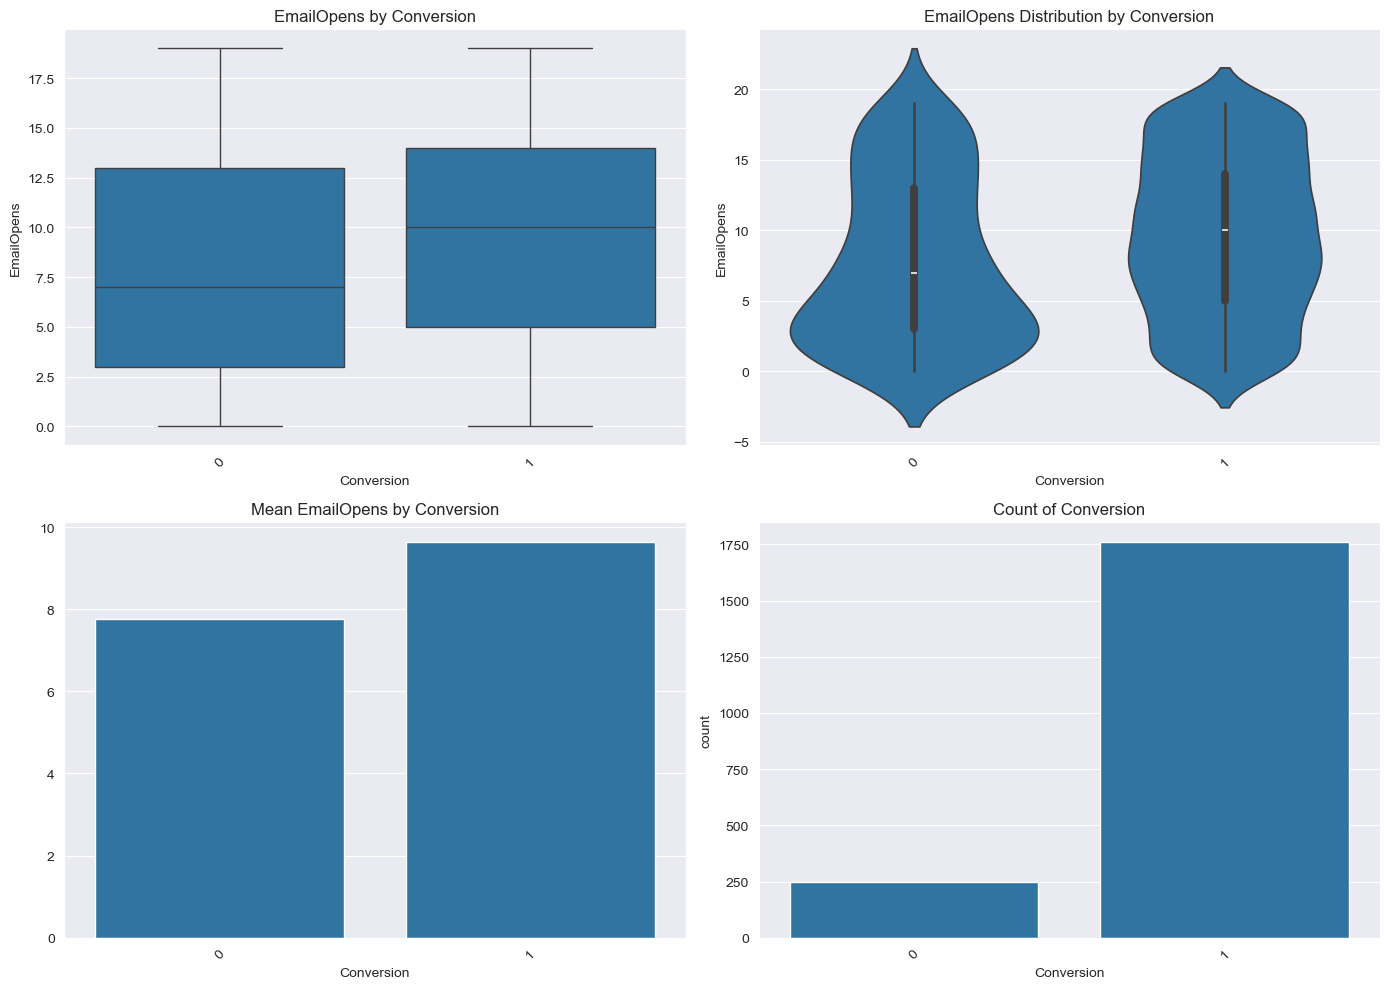

=============== Conversion vs EmailOpens ===============
Group Statistics:
             count      mean       std  min  25%   50%   75%   max
Conversion                                                        
0            248.0  7.758065  5.879176  0.0  3.0   7.0  13.0  19.0
1           1762.0  9.643587  5.684102  0.0  5.0  10.0  14.0  19.0

Normality Test Results (Shapiro-Wilk):
0: p-value = 0.00000, Normal = False
1: p-value = 0.00000, Normal = False

Welch's ANOVA Test Results:
                                     
test_used               Welch's ANOVA
all_groups_normal               False
f_statistic                  21.73873
p_value                       0.00000
significant_difference           True
num_categories                      2
total_observations               2010


In [327]:

describe_cat_num_relationship(df , "Conversion", "EmailOpens")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین تعداد باز کردن ایمیل‌ها (<strong>EmailOpens</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>Box Plot:</strong> میانه تعداد باز کردن ایمیل در گروه تبدیل‌شده (۱۰) به‌وضوح بالاتر از گروه غیرتبدیل‌شده (۷) است. همچنین دامنه بین چارک‌ها در گروه تبدیل‌شده فشرده‌تر و متمرکزتر است.</li>
    <li><strong>Violin Plot:</strong> تراکم داده‌ها در گروه تبدیل‌شده بیشتر در محدوده‌های بالاتر EmailOpens دیده می‌شود، که نشان‌دهنده ارتباط مثبت بین تعامل ایمیلی و احتمال تبدیل است.</li>
    <li><strong>Bar Plot میانگین EmailOpens:</strong> میانگین تعداد باز کردن ایمیل برای گروه تبدیل‌شده حدود ۹.۶۴ است، در حالی که این مقدار برای گروه غیرتبدیل‌شده حدود ۷.۷۵ است.</li>
    <li><strong>Bar Plot تعداد Conversion:</strong> تعداد نمونه‌های تبدیل‌شده (۱۷۶۲) بسیار بیشتر از نمونه‌های غیرتبدیل‌شده (۲۴۸) است، که می‌تواند ناشی از تعامل بیشتر با کمپین‌های ایمیلی باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون نرمال بودن (Shapiro-Wilk) برای هر دو گروه مقدار p را صفر گزارش کرده، که نشان‌دهنده غیرنرمال بودن توزیع‌هاست.</p>
  <p>آزمون <strong>Welch’s ANOVA</strong> با مقدار f برابر با ۲۱.۷۳ و <strong>p-value</strong> صفر، اختلاف معناداری بین میانگین‌های دو گروه را تأیید می‌کند.</p>
  <p>این اختلاف از نظر آماری معتبر است و نشان می‌دهد که تعداد بیشتر باز کردن ایمیل‌ها با نرخ تبدیل بالاتر همراه است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>تحلیل تصویری و آماری هر دو نشان می‌دهند که کاربران با تعامل بیشتر با ایمیل‌های تبلیغاتی، احتمال تبدیل بالاتری دارند.</p>
  <p>این رابطه از نظر آماری معنادار بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، شاخص EmailOpens می‌تواند به‌عنوان معیار مؤثری در تحلیل اثربخشی کمپین‌های ایمیلی و بهینه‌سازی نرخ تبدیل مورد استفاده قرار گیرد.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>EmailOpens_categorized  vs Conversion</h3>
</div>

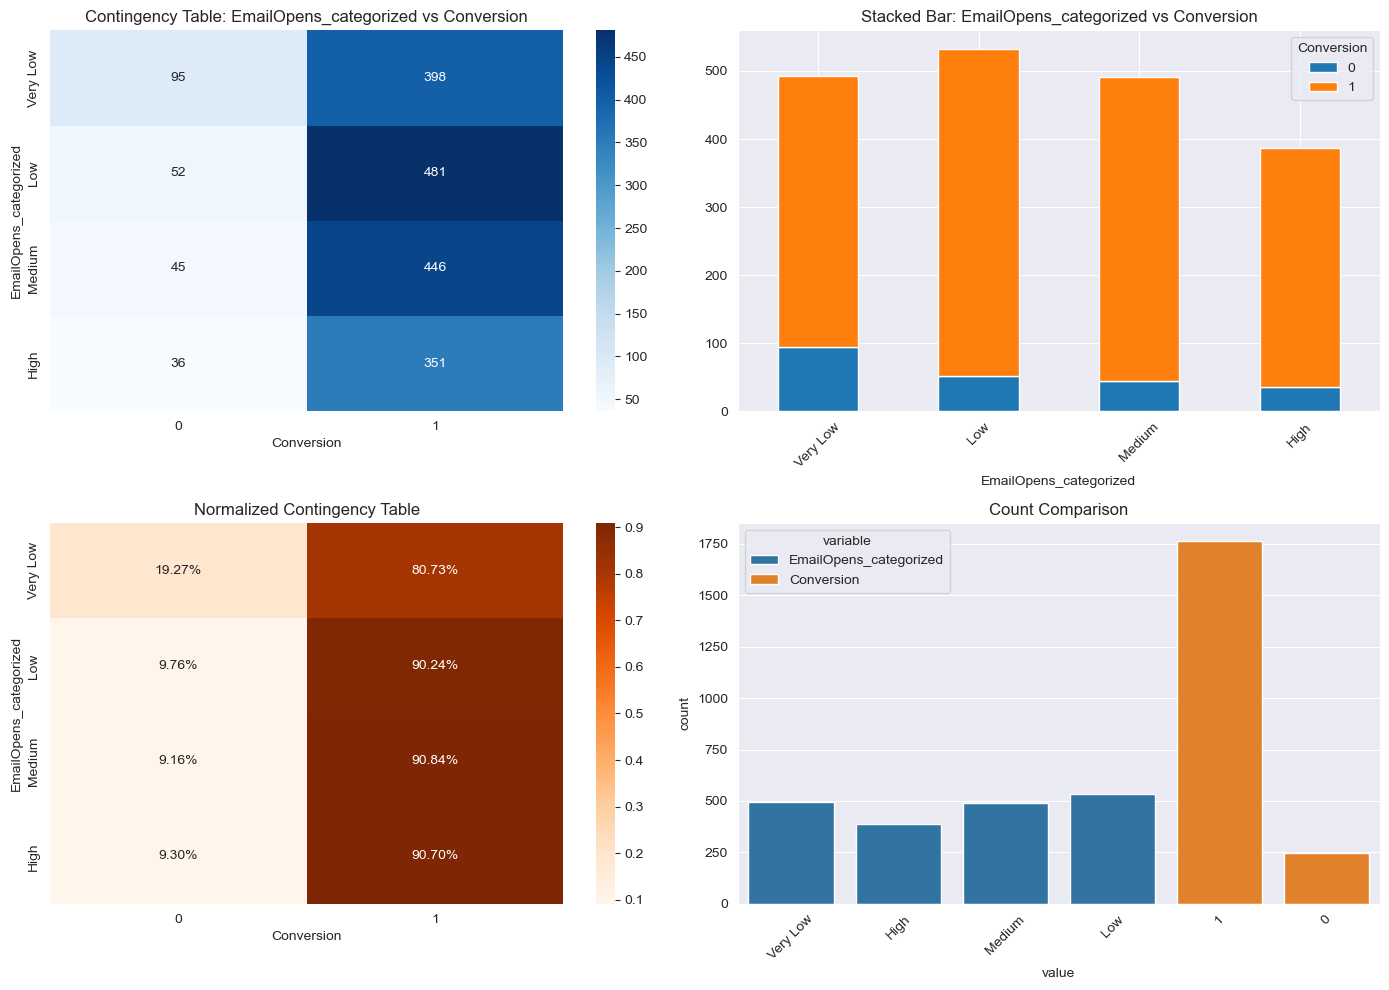

=============== EmailOpens_categorized vs Conversion ===============
Contingency Table:
Conversion               0    1
EmailOpens_categorized         
Very Low                95  398
Low                     52  481
Medium                  45  446
High                    36  351

Chi-square Test Results:
                                 
chi2_statistic           33.67866
p_value                   0.00000
degrees_of_freedom              3
cramers_v                 0.13300
association_strength     moderate
significant_association      True


In [328]:
describe_cat_cat_relationship(df, "EmailOpens_categorized", "Conversion")


<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین دسته‌های تعداد باز کردن ایمیل‌ها (<strong>EmailOpens_categorized</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>جدول فراوانی:</strong> در دسته‌های <strong>Low</strong> و <strong>Very Low</strong>، تعداد تبدیل‌شده‌ها به‌طور قابل توجهی بیشتر از غیرتبدیل‌شده‌هاست. دسته Low با ۴۸۱ تبدیل، بیشترین سهم را دارد.</li>
    <li><strong>نمودار میله‌ای انباشته:</strong> سهم تبدیل در دسته‌های با تعداد باز کردن ایمیل کمتر، به‌وضوح بیشتر است، که ممکن است نشان‌دهنده کیفیت بالای ایمیل‌ها یا هدف‌گذاری دقیق‌تر باشد.</li>
    <li><strong>جدول نرمال‌شده:</strong> درصد تبدیل در دسته Low برابر با 90.2٪ و در دسته Very Low برابر با 80.7٪ است. این اختلاف نشان‌دهنده تفاوت در اثربخشی ایمیل‌ها در دسته‌های مختلف است.</li>
    <li><strong>نمودار مقایسه تعداد:</strong> دسته‌های Low و Very Low بیشترین سهم را در تبدیل دارند، که می‌تواند نشانه‌ای از تعامل مؤثر در مراحل اولیه کمپین باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون <strong>Chi-square</strong> با مقدار آماره ۳۳.۶۷ و <strong>p-value</strong> برابر با ۰.۰۰۰۰۰، وجود ارتباط معنادار بین دسته‌های EmailOpens و Conversion را تأیید می‌کند.</p>
  <p>مقدار <strong>Cramér's V</strong> برابر با ۰.۱۳۳۰۰ است که نشان‌دهنده قدرت ارتباط متوسط است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>هم نمودارها و هم آزمون آماری نشان می‌دهند که دسته‌بندی تعداد باز کردن ایمیل‌ها با نرخ تبدیل مرتبط است.</p>
  <p>این رابطه از نظر آماری معنادار بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، EmailOpens_categorized می‌تواند به‌عنوان شاخصی مؤثر در تحلیل اثربخشی کمپین‌های ایمیلی و بهینه‌سازی نرخ تبدیل مورد استفاده قرار گیرد.</p>
</div>

<div style="font-family:Tahoma, sans-serif; direction:rtl; text-align:right; line-height:1.8; padding:20px;">
<h3>EmailClicks_categorized  vs Conversion</h3>
</div>

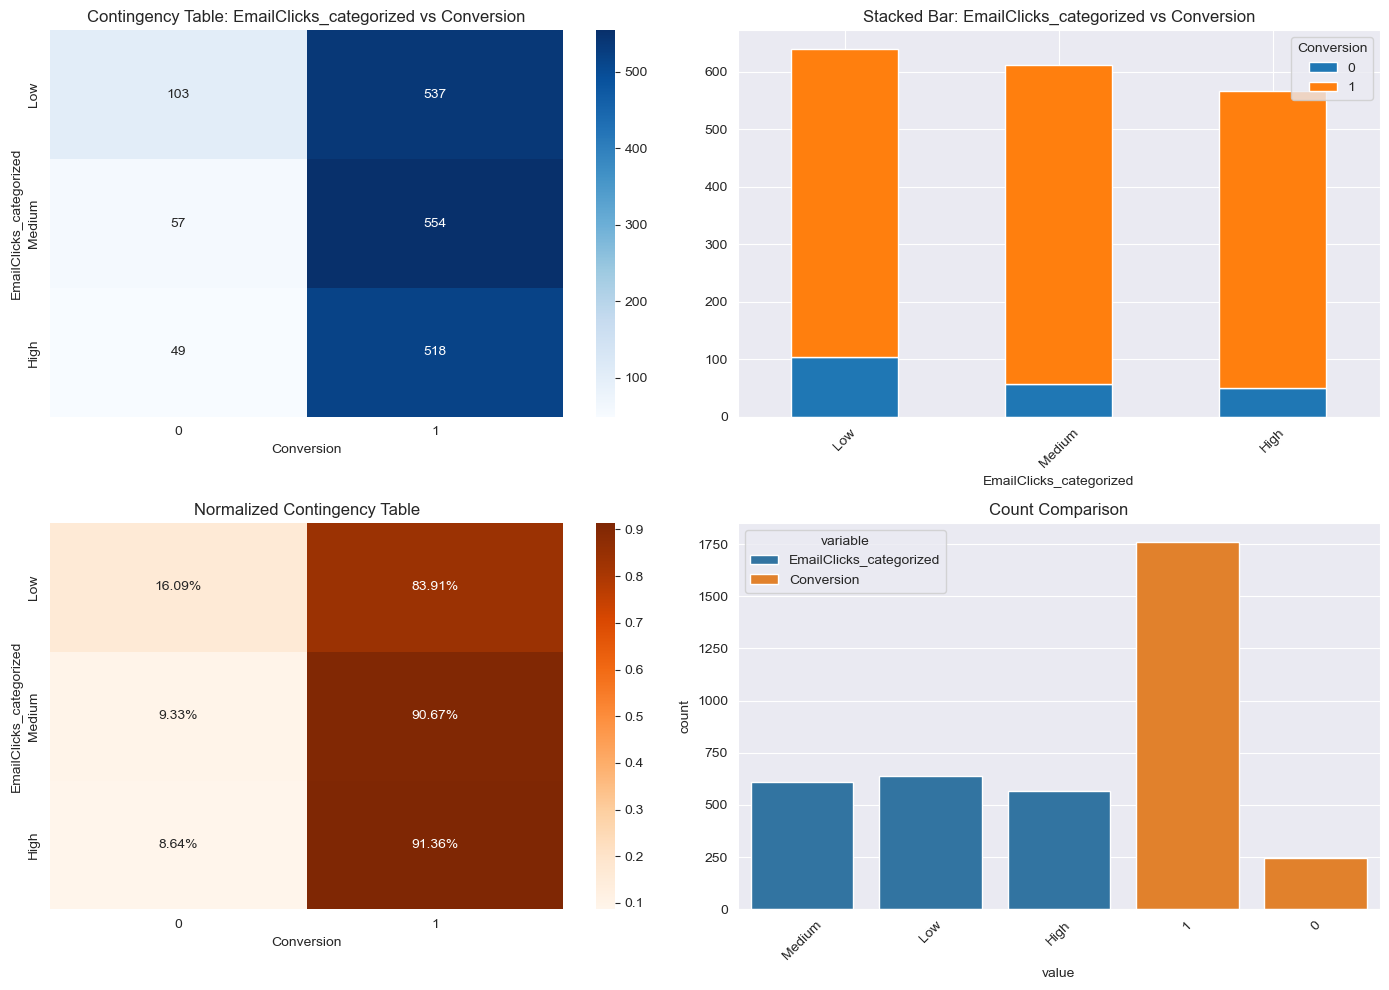

=============== EmailClicks_categorized vs Conversion ===============
Contingency Table:
Conversion                 0    1
EmailClicks_categorized          
Low                      103  537
Medium                    57  554
High                      49  518

Chi-square Test Results:
                                 
chi2_statistic           20.65637
p_value                   0.00003
degrees_of_freedom              2
cramers_v                 0.10659
association_strength     moderate
significant_association      True


In [329]:
describe_cat_cat_relationship(df , "EmailClicks_categorized", "Conversion")

<div style="font-family:Tahoma, sans-serif; line-height:1.8; direction:rtl; text-align:right; padding:20px;">
  <h2 style="color:#2c3e50;">تحلیل نمودارها</h2>
  <p>نمودارهای ارائه‌شده رابطه بین دسته‌های تعداد کلیک‌های ایمیلی (<strong>EmailClicks_categorized</strong>) و وضعیت تبدیل (<strong>Conversion</strong>) را از زوایای مختلف بررسی می‌کنند:</p>
  <ul>
    <li><strong>جدول فراوانی:</strong> در هر سه دسته Low، Medium و High، تعداد تبدیل‌شده‌ها به‌طور قابل توجهی بیشتر از غیرتبدیل‌شده‌هاست. دسته Medium با ۵۵۴ تبدیل، بیشترین سهم را دارد.</li>
    <li><strong>نمودار میله‌ای انباشته:</strong> سهم تبدیل در دسته‌های با کلیک بیشتر به‌وضوح بالاتر است، که نشان‌دهنده ارتباط مثبت بین تعامل ایمیلی و احتمال تبدیل است.</li>
    <li><strong>جدول نرمال‌شده:</strong> درصد تبدیل در دسته High برابر با ۹۱.۳٪ و در دسته Low برابر با ۸۳.۹٪ است. این اختلاف نشان‌دهنده تأثیر تعداد کلیک‌های ایمیلی بر رفتار تبدیل کاربران است.</li>
    <li><strong>نمودار مقایسه تعداد:</strong> دسته‌های Medium و High بیشترین سهم را در تبدیل دارند، که می‌تواند نشانه‌ای از اثربخشی کمپین‌های ایمیلی با CTA قوی‌تر باشد.</li>
  </ul>

  <h2 style="color:#2c3e50;">تحلیل آماری مقادیر</h2>
  <p>آزمون <strong>Chi-square</strong> با مقدار آماره ۲۰.۶۵ و <strong>p-value</strong> برابر با ۰.۰۰۰۰۳، وجود ارتباط معنادار بین دسته‌های EmailClicks و Conversion را تأیید می‌کند.</p>
  <p>مقدار <strong>Cramér's V</strong> برابر با ۰.۱۰۶۵۹ است که نشان‌دهنده قدرت ارتباط متوسط است.</p>

  <h2 style="color:#2c3e50;">جمع‌بندی</h2>
  <p>هم نمودارها و هم آزمون آماری نشان می‌دهند که کاربران با تعداد کلیک ایمیلی بیشتر، احتمال تبدیل بالاتری دارند.</p>
  <p>این رابطه از نظر آماری معنادار بوده و در نمودارها نیز به‌وضوح قابل مشاهده است.</p>
  <p>بنابراین، EmailClicks_categorized می‌تواند به‌عنوان شاخصی مؤثر در تحلیل اثربخشی کمپین‌های ایمیلی، طراحی CTA، و بهینه‌سازی نرخ تبدیل مورد استفاده قرار گیرد.</p>
</div>